In [1]:
import pickle

from pathlib import Path
import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyfaidx import Fasta
from meth5 import MetH5File

from nanoepitools.plotting.general_plotting import PlotArchiver, plot_2d_density
from nanoepitools.reference_cpgs import ReferenceCpGs

from benchmark_pycometh.simulation.nanopolish_simulator import OmicsSimlaLoader
from benchmark_pycometh.utils import unions
from benchmark_pycometh.config import module_config
from benchmark_pycometh.diffmet.asm_results import Results

In [4]:
pa = PlotArchiver("simulation", headless=False, config={"plot_archive_dir": "/home/r933r/snajder/nanoepitools_plots/benchmark"})
reference_cpgs = ReferenceCpGs("/home/r933r/data/resource/human/hg19/hg19_no_chr.fa")
simulated_m5 = "/home/r933r/data/projects/nanopore/pycometh_benchmark/simulated/diffmet_merged_2_rewritten.m5"
results_cache_file = "/home/r933r/data/projects/nanopore/pycometh_benchmark/simulated/all_results_cache.pkl"
load_from_cache=True

In [5]:
def get_result_file(caller, segmentation=None, test=None, ihw=False, segments_per_window=None, window_size=None):
    simdir = Path("/home/r933r/data/projects/nanopore/pycometh_benchmark/simulated/")
    if caller == "gt":
        return simdir.joinpath("wgbs/merged/changepoints.txt")
    simdir = simdir.joinpath(segmentation)
    if caller == "methcp":
        return simdir.joinpath("methcp_dmr_2.bed")
    ihw = f"ihw_{'yes' if ihw else 'no'}"
    if segmentation == "pycometh":
        simfile = f"diffmet_{window_size}_{segments_per_window}_hyp_{test}_{ihw}.tsv"
        return simdir.joinpath("diffmet", simfile)
    if caller == "pycometh":
        return simdir.joinpath(f"pycometh_methcomp/diffmet/diffmet_hyp_{test}_{ihw}.tsv")

def get_all_result_files():
    yield {"key":"GT", "file":get_result_file("gt"), "caller": "gt"}
    yield {"key":"MethCP", "file":get_result_file("methcp", "methcp"), "caller": "methcp"}
    for label, segmentation in  ("PycoMeth", "pycometh"), ("PycoMeth (MethylKit)", "methylkit"), ("PycoMeth (MethCP)", "methcp"):
        for ihw in True, False:
            for test_label, test in ("BS Diff", "bs_diff"), ("LLR-Diff", "llr_diff"), ("Fisher-E","count_dependency"):
                name = f"{label} {test_label}{' (IHW)' if ihw else ''}"
                if segmentation == "pycometh":
                    yield {"key": name + " coarse", "caller": "pycometh", "file": get_result_file("pycometh", segmentation, test, ihw, 16, 600)}
                    yield {"key": name, "caller": "pycometh", "file": get_result_file("pycometh", segmentation, test, ihw, 16, 300)}
                else:
                    yield {"key": name, "caller": "pycometh", "file": get_result_file("pycometh", segmentation, test, ihw)}

In [6]:
if load_from_cache:
    with open(results_cache_file, "rb") as f:
        results = pickle.load(f)
else:
    results = Results(reference_cpgs, simulated_m5, read_group_key="sample")

In [5]:
import importlib
import benchmark_pycometh.diffmet.asm_results
importlib.reload(benchmark_pycometh.diffmet.asm_results)
results.__class__ = benchmark_pycometh.diffmet.asm_results.Results

In [6]:
for res_config in get_all_result_files():
    if res_config["key"] not in results.segments:
        results.load_segments(**res_config)

with open(results_cache_file, "bw") as f:
    del results.reference_cpgs.ref
    pickle.dump(results, f)

Loading GT
Annotating CpGs for GT
Loading diffmet for GT (6830 segments)
Finished loading GT (6755 segments)
Loading MethCP
Annotating CpGs for MethCP
Loading diffmet for MethCP (4089 segments)
Finished loading MethCP (4089 segments)
Loading PycoMeth BS Diff (IHW) coarse
Annotating CpGs for PycoMeth BS Diff (IHW) coarse
Loading diffmet for PycoMeth BS Diff (IHW) coarse (4849 segments)
Finished loading PycoMeth BS Diff (IHW) coarse (4849 segments)
Loading PycoMeth BS Diff (IHW)
Annotating CpGs for PycoMeth BS Diff (IHW)
Loading diffmet for PycoMeth BS Diff (IHW) (8366 segments)
Finished loading PycoMeth BS Diff (IHW) (8364 segments)
Loading PycoMeth LLR-Diff (IHW) coarse
Annotating CpGs for PycoMeth LLR-Diff (IHW) coarse
Loading diffmet for PycoMeth LLR-Diff (IHW) coarse (4941 segments)
Finished loading PycoMeth LLR-Diff (IHW) coarse (4941 segments)
Loading PycoMeth LLR-Diff (IHW)
Annotating CpGs for PycoMeth LLR-Diff (IHW)
Loading diffmet for PycoMeth LLR-Diff (IHW) (8264 segments)
Fin

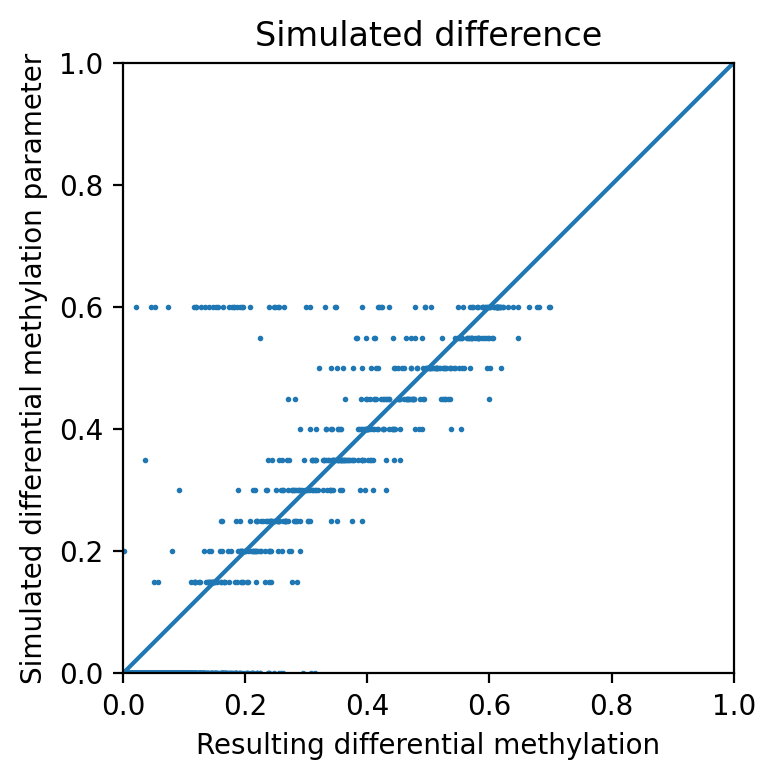

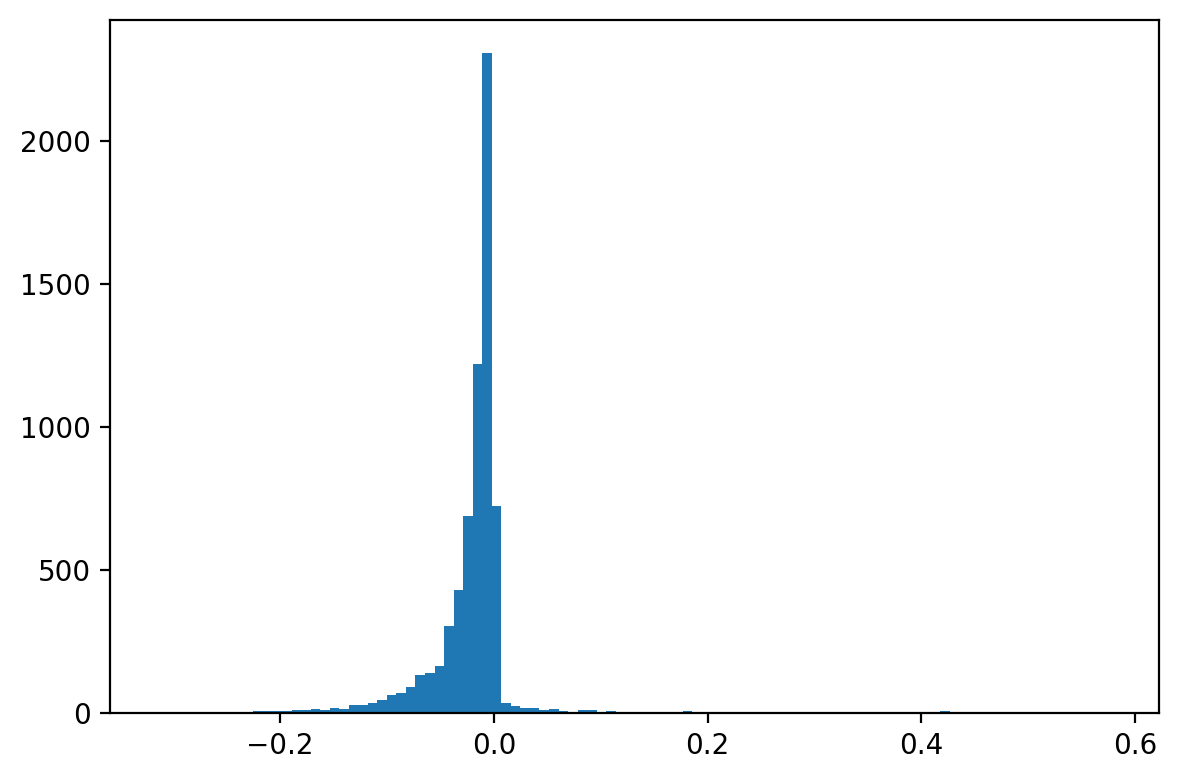

In [7]:
pa.figure()
plt.title("Simulated difference")
plt.scatter(results.segments["GT"]["diffmet"], np.abs(results.segments["GT"]["theta"]), s=1)
plt.xlabel("Resulting differential methylation")
plt.ylabel("Simulated differential methylation parameter")
plt.plot([0,1], [0,1])
plt.xlim(0,1)
plt.ylim(0,1)
plt.gca().set_aspect("equal")
pa.saveandshow("simulated_difference_vs_parameters")

pa.figure()
plt.hist(np.abs(results.segments["GT"]["theta"]) - results.segments["GT"]["diffmet"], bins=100)
plt.show()

In [8]:
class ResultComparer:
    def __init__(self, segments):
        self.segments = {k:v.copy() for k,v in segments.items()}

    def remove_cpgs_not_in_gt(self, gt_key):
        """
        Removing a small number of CpGs that fell through the cracks
        as they are in between block sin the simulation
        """
        allowed_cgs = unions(self.segments[gt_key]["CpGs"])
        for key in self.segments:
            if key == gt_key:
                continue
            self.segments[key]["CpGs"] = self.segments[key]["CpGs"].map(lambda cpgs: cpgs.intersection(allowed_cgs))

    def get(self, key, diffmet_threshold=0.1, below_threshold=False, theta_threshold=0, pval_threshold = 1):
        ret = self.segments[key]

        idx = ret["diffmet"].map(lambda x: abs(x)>=diffmet_threshold)
        if theta_threshold != 0:
            idx = idx & ret["theta"].map(lambda x: abs(x) >= theta_threshold)

        if below_threshold:
            idx = ~idx

        if pval_threshold < 1:
            idx = idx & (ret["adj_pvalue"] < pval_threshold)

        return ret.loc[idx]

    def compute_tpr(self, gt, pred, diffmet_threshold=0.1, theta_threshold=0.1, pval_threshold=0.05):
        pred = self.get(pred, diffmet_threshold=diffmet_threshold, pval_threshold=pval_threshold)
        pred_cgs = unions(pred["CpGs"])
        gt_pos = self.get(gt, diffmet_threshold=0, theta_threshold=theta_threshold)
        gt_pos_cgs = unions(gt_pos["CpGs"])
        num_gt_pos = len(gt_pos_cgs)
        num_true_pos = len(gt_pos_cgs.intersection(pred_cgs))
        if num_gt_pos == 0:
            return np.nan
        return num_true_pos / num_gt_pos

    def compute_precision(self, gt, pred, diffmet_threshold=0.1, theta_threshold=0.1, pval_threshold=0.05):
        pred = self.get(pred, diffmet_threshold=diffmet_threshold, pval_threshold=pval_threshold)
        pred_cgs = unions(pred["CpGs"])
        gt_pos = self.get(gt, diffmet_threshold=0, theta_threshold=theta_threshold)
        gt_pos_cgs = unions(gt_pos["CpGs"])
        num_true_pos = len(gt_pos_cgs.intersection(pred_cgs))
        num_pred = len(pred_cgs)

        if num_pred == 0:
            return np.nan
        return num_true_pos / num_pred

    def compute_fpr(self, gt, pred, diffmet_threshold=0.1, theta_threshold=0.1, pval_threshold = 0.05):
        pred = self.get(pred, diffmet_threshold=diffmet_threshold, pval_threshold=pval_threshold)
        pred_cgs = unions(pred["CpGs"])
        gt_neg = self.get(gt, diffmet_threshold=0, below_threshold=True, theta_threshold=theta_threshold)
        gt_neg_cgs = unions(gt_neg["CpGs"])
        num_gt_neg = len(gt_neg_cgs)
        num_false_pos = len(gt_neg_cgs.intersection(pred_cgs))
        if num_gt_neg == 0:
            return np.nan
        return num_false_pos / num_gt_neg

    def compute_fdr(self, gt, pred, diffmet_threshold=0.1, theta_threshold=0.1, pval_threshold=0.05):
        pred = self.get(pred, diffmet_threshold=diffmet_threshold, pval_threshold=pval_threshold)
        pred_cgs = unions(pred["CpGs"])
        gt_neg = self.get(gt, diffmet_threshold=0, below_threshold=True, theta_threshold=theta_threshold)
        gt_neg_cgs = unions(gt_neg["CpGs"])
        num_pred = len(pred_cgs)
        num_false_pos = len(gt_neg_cgs.intersection(pred_cgs))
        if num_pred == 0:
            return np.nan
        return num_false_pos / num_pred

    def compute_predicted_effect_size_precision(self, gt, pred, diffmet_threshold=0.2, theta_threshold=0.1, pval_threshold=0.05):
        self.segments["temp"] = self.segments[pred].loc[self.segments[pred]["diffmet"].map(lambda x: abs(x) < diffmet_threshold)]
        pred = self.get("temp", diffmet_threshold=0.1, pval_threshold=pval_threshold)
        pred_cgs = unions(pred["CpGs"])
        gt_pos = self.get(gt, diffmet_threshold=0, theta_threshold=theta_threshold)
        gt_pos_cgs = unions(gt_pos["CpGs"])
        num_true_pos = len(gt_pos_cgs.intersection(pred_cgs))
        num_pred = len(pred_cgs)

        if num_pred == 0:
            return np.nan
        return num_true_pos / num_pred

    def compute_predicted_effect_size_recall(self, gt, pred, diffmet_threshold=0.2, theta_threshold=0.1, pval_threshold=0.05):
        self.segments["temp"] = self.segments[gt].loc[self.segments[gt]["theta"].map(lambda x: abs(x) < diffmet_threshold)]
        gt_pos = self.get("temp", diffmet_threshold=0.1)
        pred = self.get(pred, diffmet_threshold=0.1, pval_threshold=pval_threshold)
        pred_cgs = unions(pred["CpGs"])
        gt_pos_cgs = unions(gt_pos["CpGs"])
        num_true_pos = len(gt_pos_cgs.intersection(pred_cgs))
        num_pos = len(gt_pos_cgs)

        if num_pos == 0:
            return np.nan
        return num_true_pos / num_pos

    def compute_discovery_counts(self, gt, pred, diffmet_threshold=0.1, theta_threshold=0.1, pval_threshold=0.05):
        pred = self.get(pred, diffmet_threshold=diffmet_threshold, pval_threshold=pval_threshold)
        pred_cgs = unions(pred["CpGs"])

        gt_neg = self.get(gt, diffmet_threshold=0, below_threshold=True, theta_threshold=theta_threshold)
        gt_pos = self.get(gt, diffmet_threshold=0, theta_threshold=theta_threshold)
        gt_neg_cgs = unions(gt_neg["CpGs"])
        gt_pos_cgs = unions(gt_pos["CpGs"])
        num_false_pos = len(gt_neg_cgs.intersection(pred_cgs))
        num_true_pos = len(gt_pos_cgs.intersection(pred_cgs))
        return num_false_pos, num_true_pos

In [49]:
def plot_measures(gt, title="", figurename=None, tool_colors=None, tool_patterns={}, theta_threshold = 0.1, diffmet_threshold=0.15):
    if tool_colors is None:
        tool_colors = {k:v for k,v in results.colors.items() if k != "GT"}
    if tool_patterns is None:
        tool_patterns = {k:v for k,v in results.patterns.items() if k != "GT"}

    recall = []
    precision = []
    f1 = []

    rc = ResultComparer(results.segments)
    rc.segments["GT"] = gt
    rc.remove_cpgs_not_in_gt("GT")

    for tool in tool_colors:
        p = 1-rc.compute_fdr("GT", tool, pval_threshold=0.05, theta_threshold=theta_threshold, diffmet_threshold=diffmet_threshold)
        r = rc.compute_tpr("GT", tool, pval_threshold=0.05, theta_threshold=theta_threshold, diffmet_threshold=diffmet_threshold)
        f = 2*(p*r)/(p+r)

        recall.append(r)
        precision.append(p)
        f1.append(f)
        print(tool, p, r, f)

    pa.figure(figsize=(10,5))
    plt.title(title)
    x = 0
    for y, (tool, color) in zip(recall, tool_colors.items()):
        plt.bar(x,y, width=1, color=color, hatch=tool_patterns.get(tool, ""))
        x+=1

    x+=1
    for y, (tool, color) in zip(precision, tool_colors.items()):
        plt.bar(x,y, width=1, color=color, hatch=tool_patterns.get(tool, ""))
        x+=1

    x+=1
    for y, (tool, color) in zip(f1, tool_colors.items()):
        plt.bar(x,y, width=1, color=color, label=tool, hatch=tool_patterns.get(tool, ""))
        x+=1

    xticks_locs = np.arange(len(tool_colors)/2, (len(tool_colors)+1)*3, len(tool_colors)+1)
    plt.xticks(xticks_locs, ["Recall", "Precision", "F1-score"])

    plt.legend(loc=(1.04,0))
    plt.ylim(0.6,1)
    plt.tight_layout()
    pa.saveandshow(figurename)

In [19]:
results.colors = {"GT": "gray"}
for key in results.segments:
    if key == "MethCP":
        results.colors[key] = "#88498F"
    elif "(MethCP)" in key:
        results.colors[key] = "#C492B1"
    elif "(MethylKit)" in key:
        results.colors[key] = "#49C6E5"
    elif "coarser" in key:
        results.colors[key] = "#C96300"
    elif "coarse" in key:
        results.colors[key] = "#ED7400"
    else:
        results.colors[key] = "#D58936"

results.patterns = {}
for key in results.segments:
    if "LLR-Diff" in key:
        if "IHW" in key:
            results.patterns[key] = "O"
        else:
            results.patterns[key] = "/"
    elif "BS Diff" in key:
        if "IHW" in key:
            results.patterns[key] = "."
        else:
            results.patterns[key] = "\\"
    elif "Fisher-E" in key:
        if "IHW" in key:
            results.patterns[key] = "o"
        else:
            results.patterns[key] = "-"

MethCP 0.9435343091177656 0.784276363520398 0.8565656741565696
PycoMeth Fisher-E coarse 0.9300060363277177 0.8106976855432156 0.8662631460128553
PycoMeth Fisher-E 0.8828835177225002 0.7991134426647745 0.8389124403135292
PycoMeth (MethylKit) Fisher-E 0.9188870135318393 0.7509029012429342 0.8264451932189113
PycoMeth (MethCP) Fisher-E 0.92712596207997 0.7875052818726131 0.8516310369057933


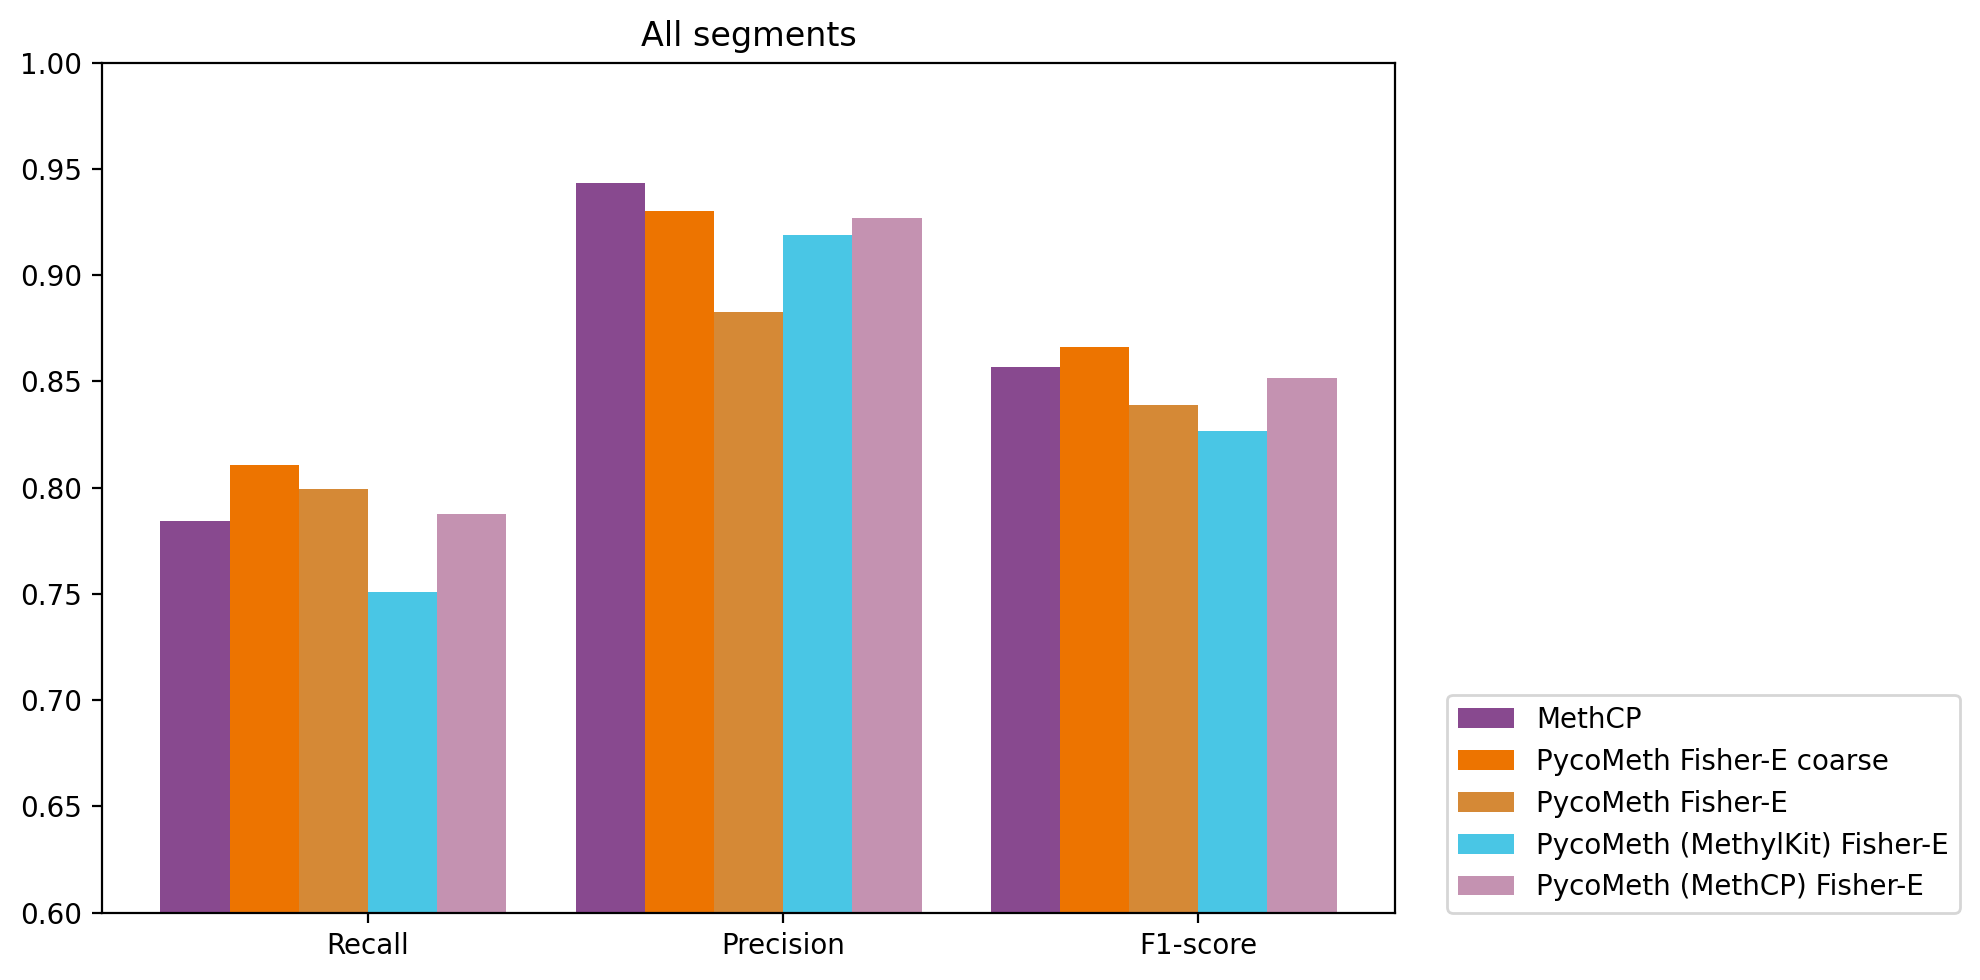

MethCP 0.9435343091177656 0.784276363520398 0.8565656741565696
PycoMeth Fisher-E (IHW) coarse 0.9277997773682002 0.8106976855432156 0.8653048373165636
PycoMeth Fisher-E (IHW) 0.9153437700265494 0.7971282558260051 0.8521556812225399
PycoMeth (MethylKit) Fisher-E (IHW) 0.9188870135318393 0.7509029012429342 0.8264451932189113
PycoMeth (MethCP) Fisher-E (IHW) 0.9243450598802395 0.7876487893549339 0.8505395830553272


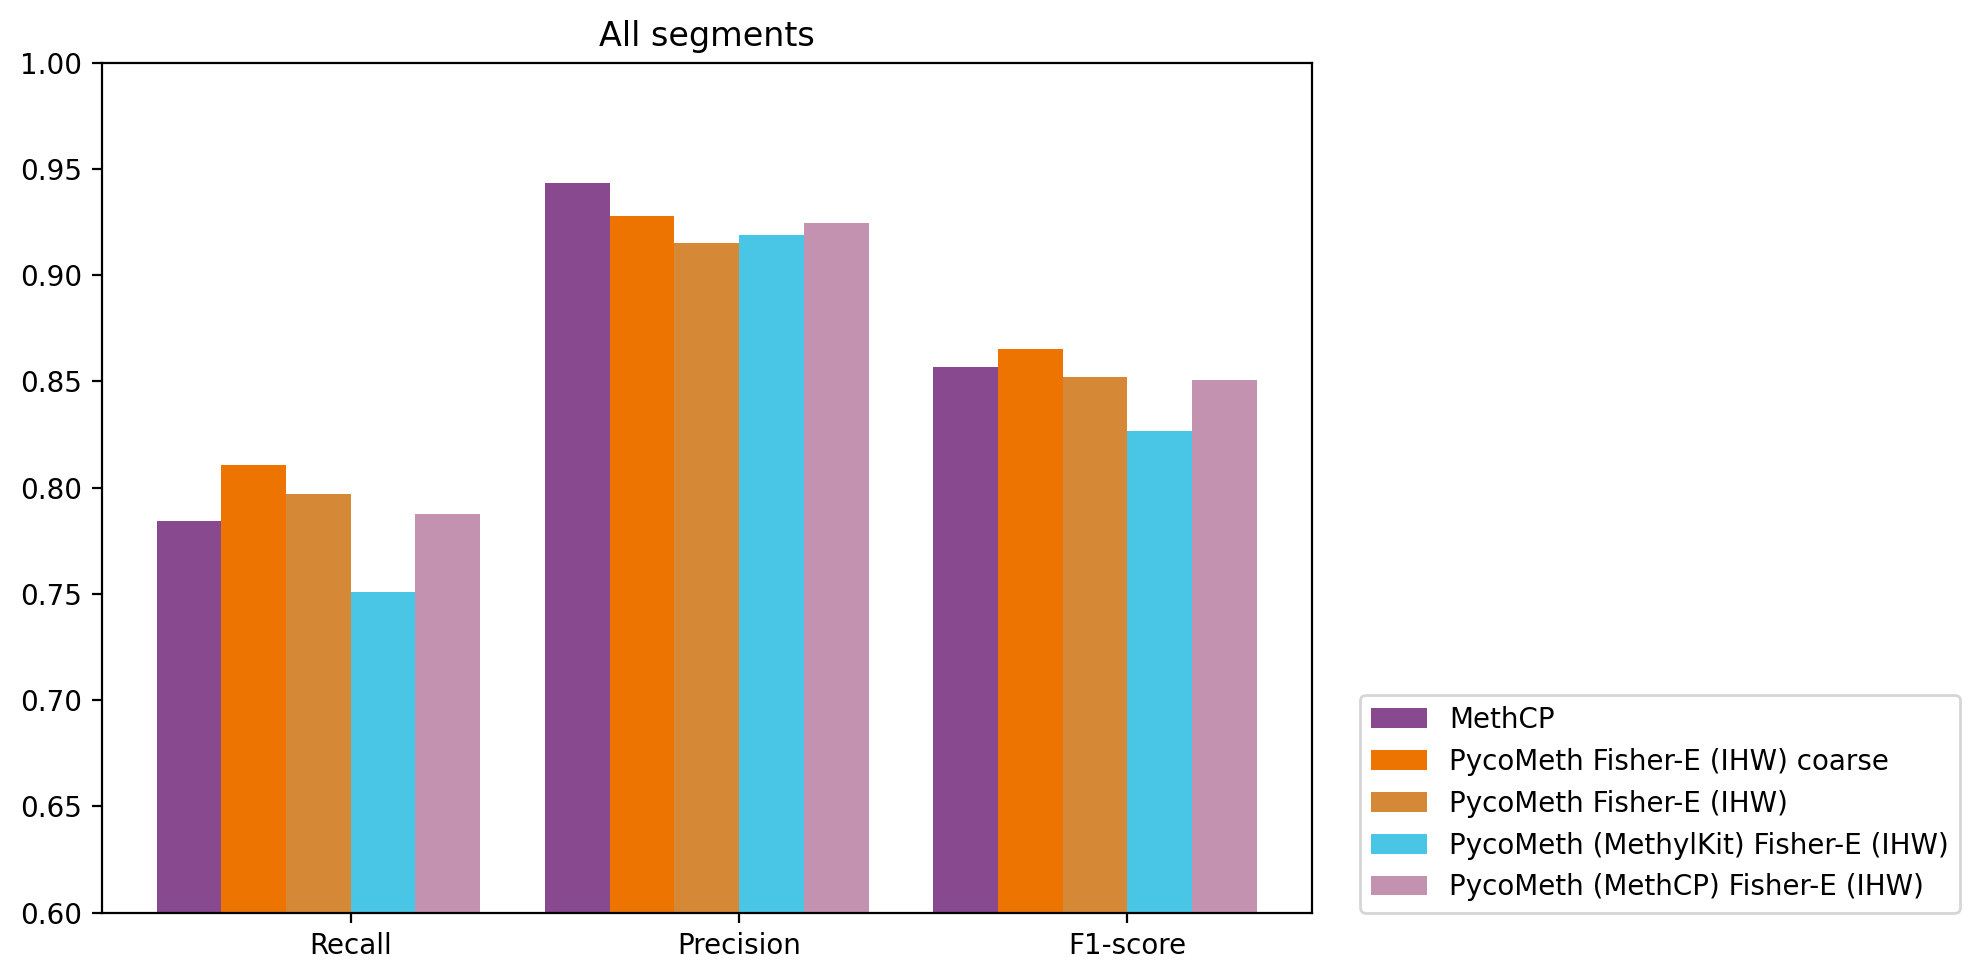

In [50]:
tools_include = ["MethCP", "PycoMeth Fisher-E coarse", "PycoMeth Fisher-E", "PycoMeth (MethylKit) Fisher-E", "PycoMeth (MethCP) Fisher-E"]
tool_colors = {k:results.colors[k] for k in tools_include}
gt = results.segments["GT"]
plot_measures(gt, "All segments", "f1_segmentations_fisher", tool_colors=tool_colors)

tools_include = ["MethCP", "PycoMeth Fisher-E (IHW) coarse", "PycoMeth Fisher-E (IHW)", "PycoMeth (MethylKit) Fisher-E (IHW)", "PycoMeth (MethCP) Fisher-E (IHW)"]
tool_colors = {k:results.colors[k] for k in tools_include}
gt = results.segments["GT"]
plot_measures(gt, "All segments", "f1_segmentations_fisher_ihw", tool_colors=tool_colors)

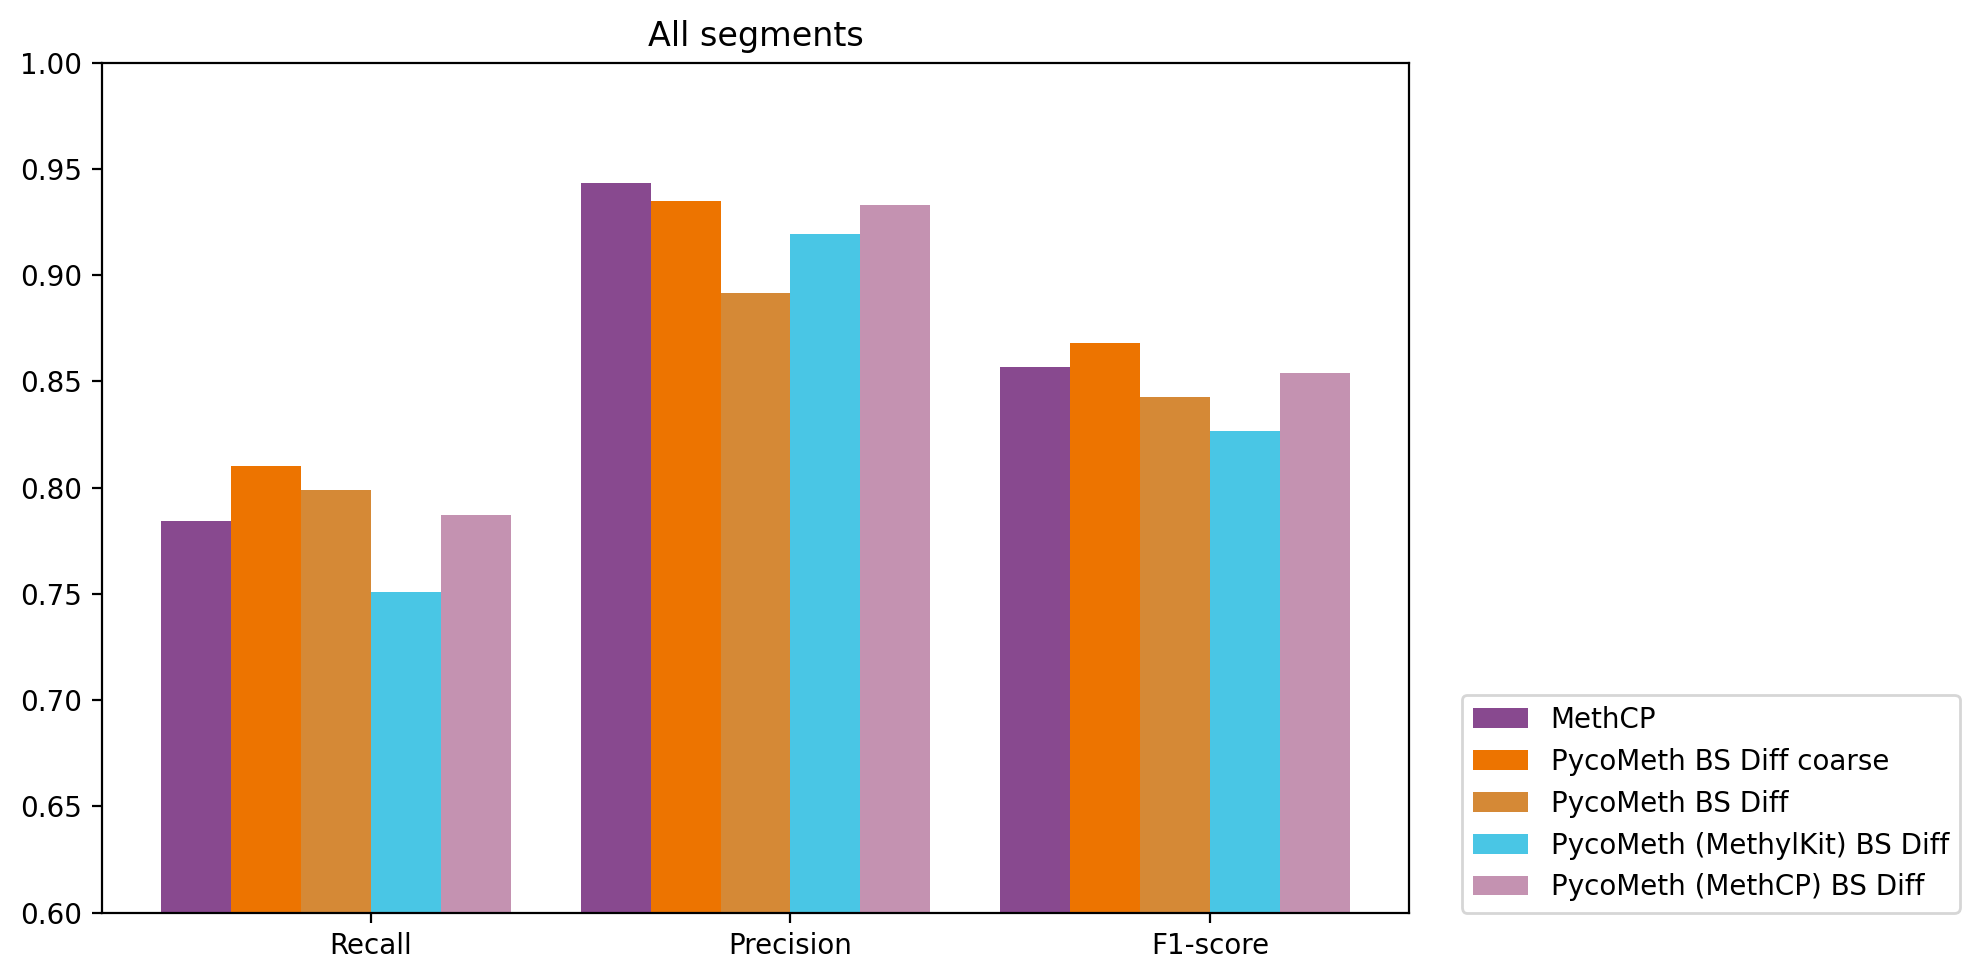

In [43]:
tools_include = ["MethCP", "PycoMeth BS Diff coarse", "PycoMeth BS Diff coarse", "PycoMeth BS Diff", "PycoMeth (MethylKit) BS Diff", "PycoMeth (MethCP) BS Diff"]
tool_colors = {k:results.colors[k] for k in tools_include}
gt = results.segments["GT"]
plot_measures(gt, "All segments", "f1_segmentations_bsdiff", tool_colors=tool_colors)

MethCP 0.9435343091177656 0.784276363520398 0.8565656741565696
PycoMeth LLR-Diff coarse 0.9305128486712058 0.8106498497157755 0.8664556179990712
PycoMeth LLR-Diff 0.8875624357929789 0.799017771009894 0.8409658268476369
PycoMeth (MethylKit) LLR-Diff 0.9188870135318393 0.7509029012429342 0.8264451932189113
PycoMeth (MethCP) LLR-Diff 0.9377629217430941 0.787321911200759 0.8559825948269885


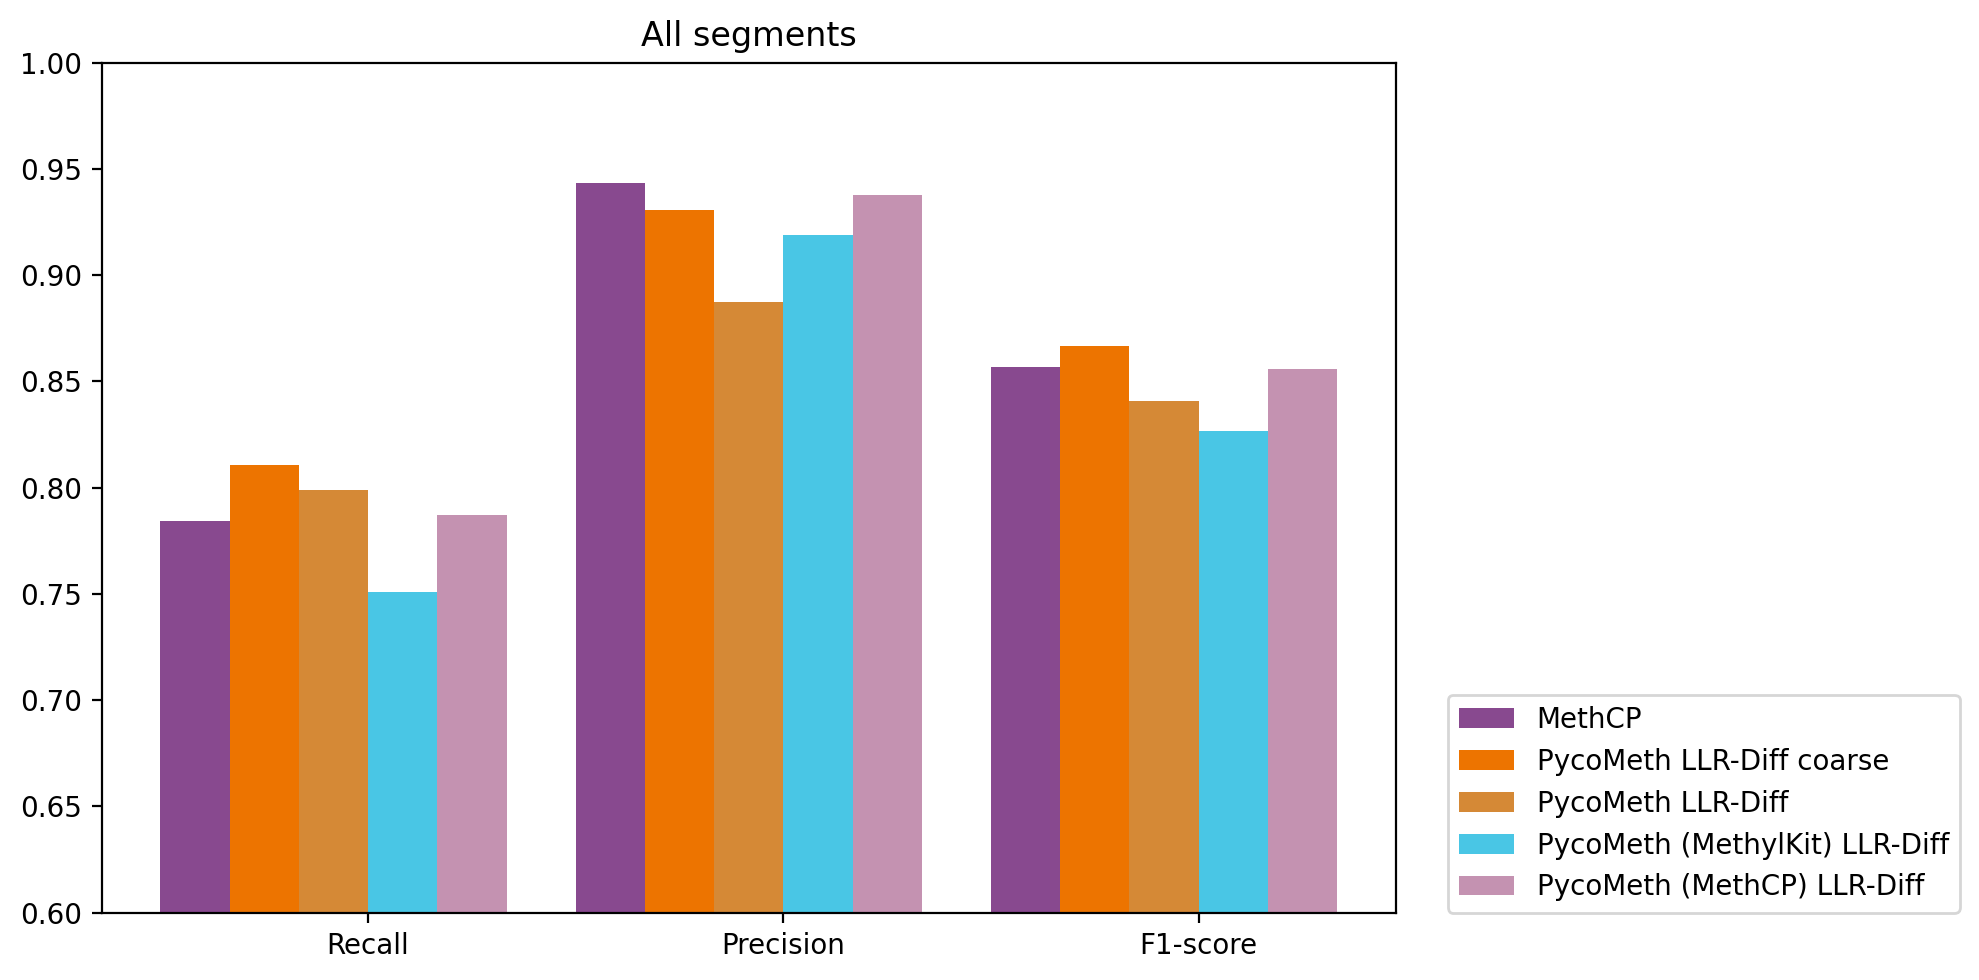

In [52]:
tools_include = ["MethCP", "PycoMeth LLR-Diff coarse", "PycoMeth LLR-Diff", "PycoMeth (MethylKit) LLR-Diff", "PycoMeth (MethCP) LLR-Diff"]
tool_colors = {k:results.colors[k] for k in tools_include}
gt = results.segments["GT"]
plot_measures(gt, "All segments", "f1_segmentations_llrdiff", tool_colors=tool_colors)

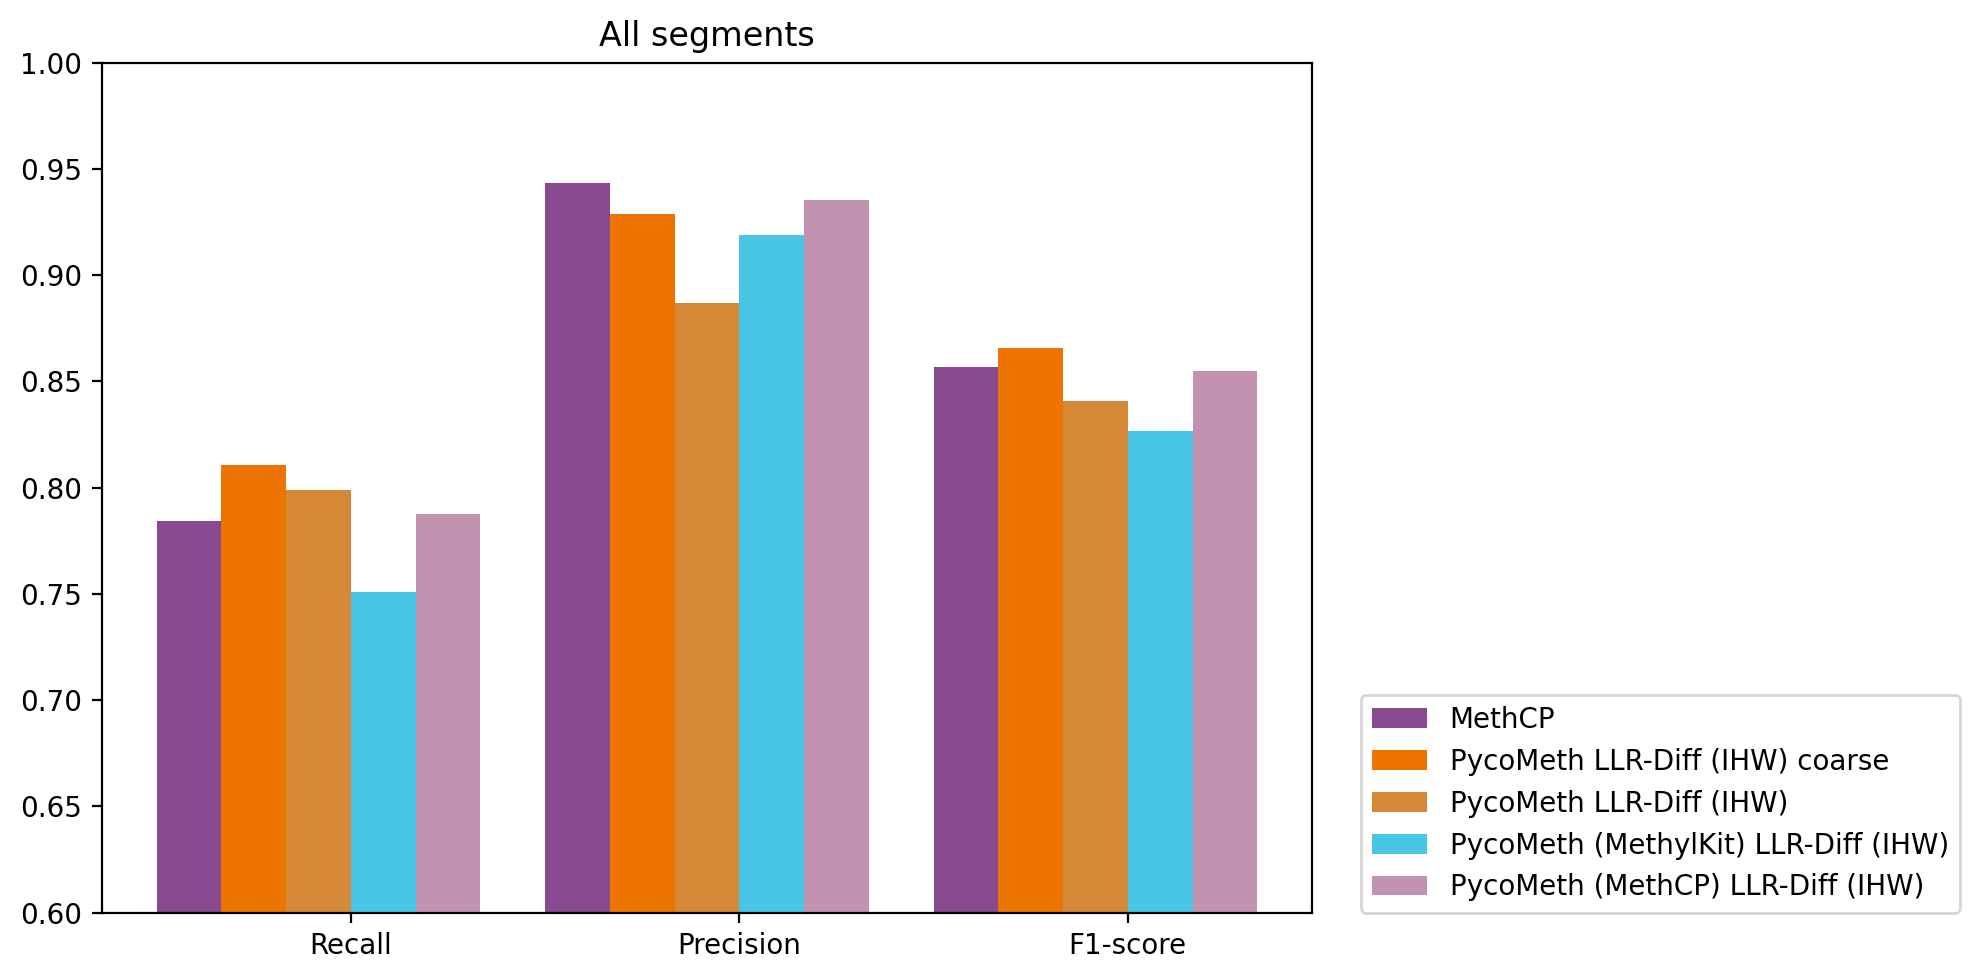

In [45]:
tools_include = ["MethCP", "PycoMeth LLR-Diff (IHW) coarse", "PycoMeth LLR-Diff (IHW)", "PycoMeth (MethylKit) LLR-Diff (IHW)", "PycoMeth (MethCP) LLR-Diff (IHW)"]
tool_colors = {k:results.colors[k] for k in tools_include}
tool_patterns = {k:results.patterns.get(k,"") for k in tools_include}
gt = results.segments["GT"]
plot_measures(gt, "All segments", "f1_segmentations_llrdiff_ihw", tool_colors=tool_colors)

MethCP 0.9435343091177656 0.784276363520398 0.8565656741565696
PycoMeth Fisher-E (IHW) coarse 0.9277997773682002 0.8106976855432156 0.8653048373165636
PycoMeth Fisher-E coarse 0.9300060363277177 0.8106976855432156 0.8662631460128553
PycoMeth LLR-Diff (IHW) coarse 0.9290086238398012 0.8107614666464693 0.8658665860625903
PycoMeth LLR-Diff coarse 0.9305128486712058 0.8106498497157755 0.8664556179990712
PycoMeth BS Diff (IHW) coarse 0.9311753124856921 0.8107295760948425 0.8667882745041214
PycoMeth BS Diff coarse 0.9349583774088213 0.8103708073890408 0.8682178488451551


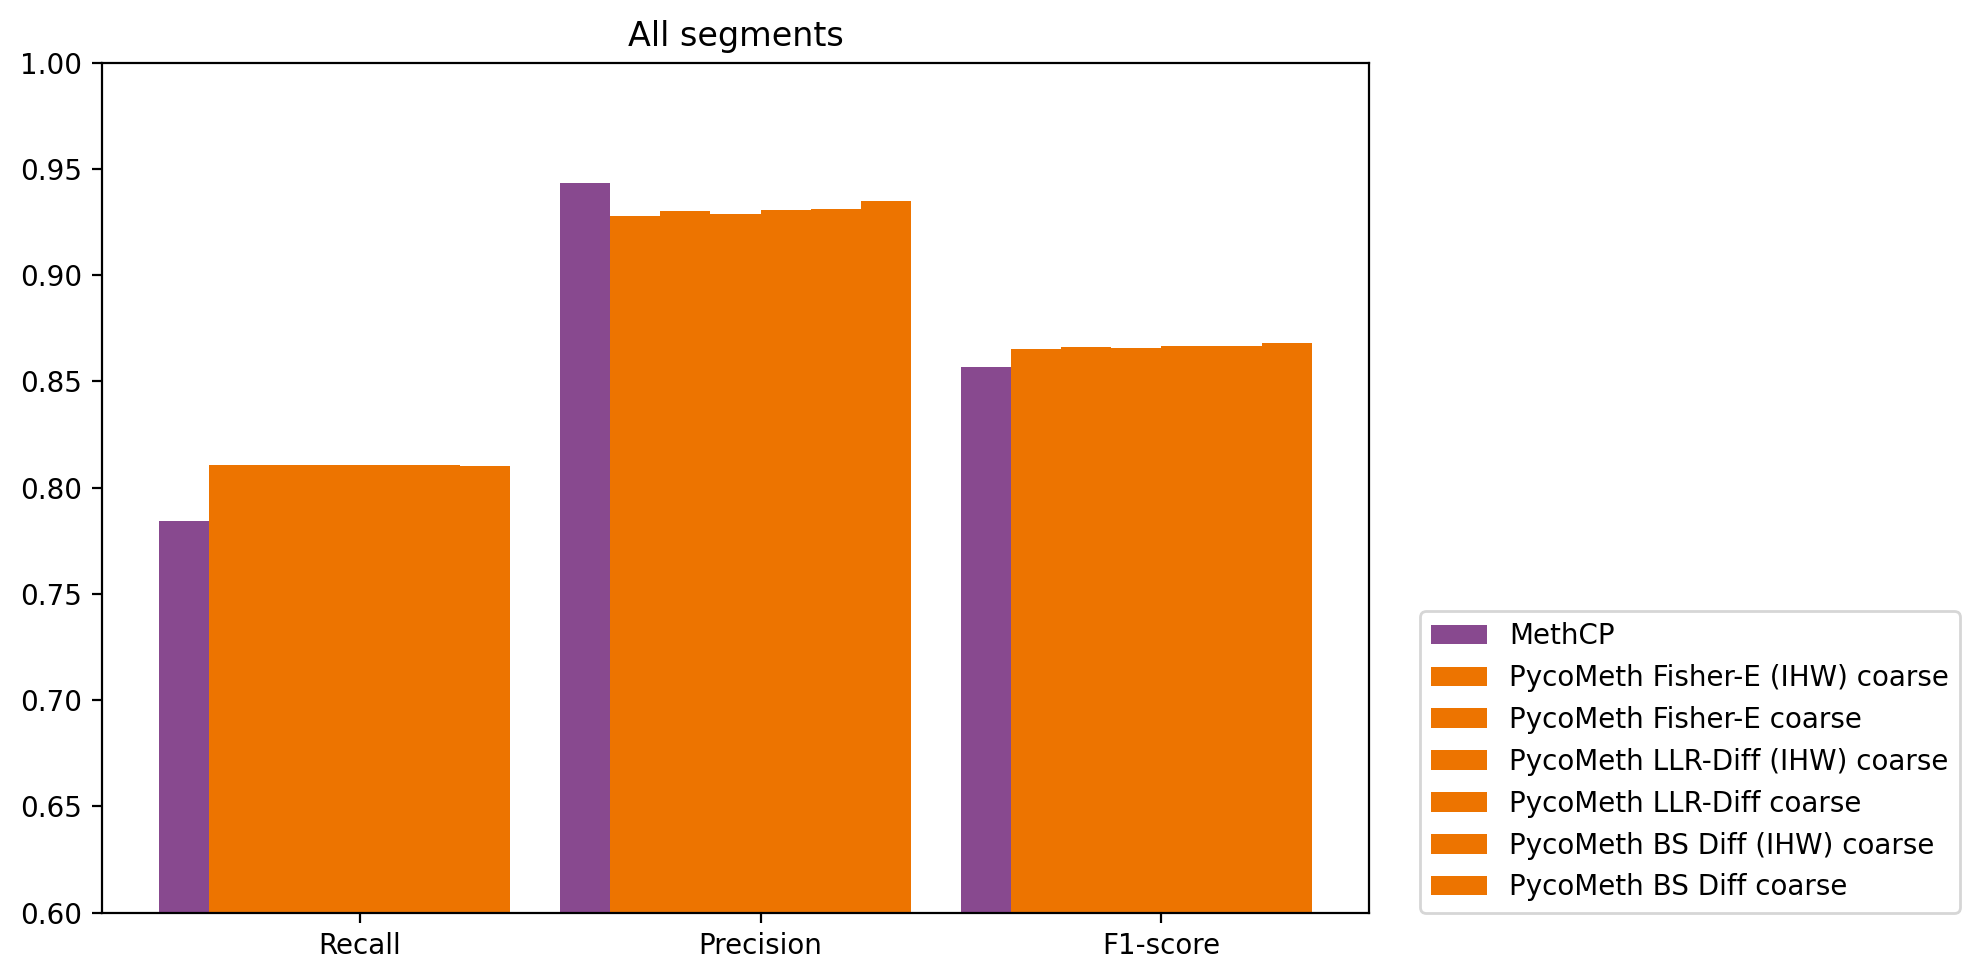

In [51]:
tools_include = ["MethCP", "PycoMeth Fisher-E (IHW) coarse", "PycoMeth Fisher-E coarse", "PycoMeth LLR-Diff (IHW) coarse", "PycoMeth LLR-Diff coarse", "PycoMeth BS Diff (IHW) coarse", "PycoMeth BS Diff coarse"]
tool_colors = {k:results.colors[k] for k in tools_include}
tool_patterns = {k:results.patterns.get(k,"") for k in tools_include}
gt = results.segments["GT"]
plot_measures(gt, "All segments", "f1_tests", tool_colors=tool_colors, tool_patterns={})

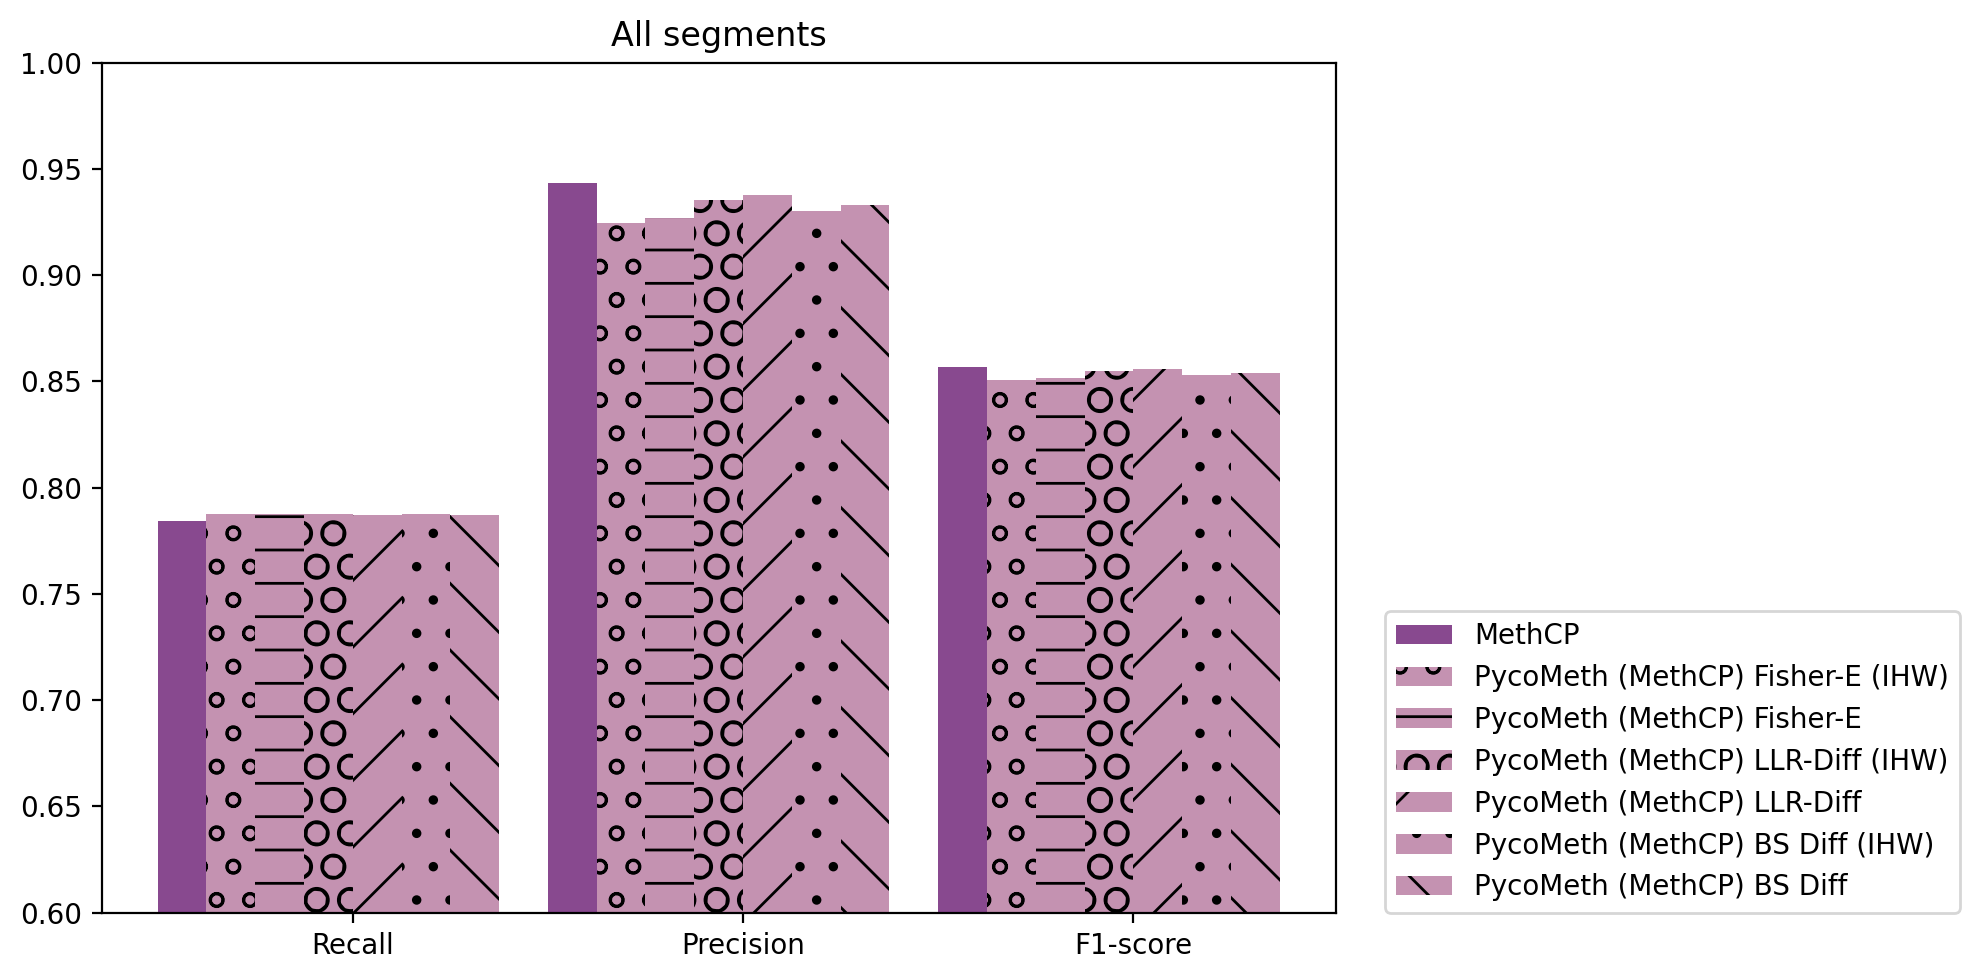

In [47]:
tools_include = ["MethCP", "PycoMeth (MethCP) Fisher-E (IHW)", "PycoMeth (MethCP) Fisher-E", "PycoMeth (MethCP) LLR-Diff (IHW)", "PycoMeth (MethCP) LLR-Diff", "PycoMeth (MethCP) BS Diff (IHW)", "PycoMeth (MethCP) BS Diff"]
tool_colors = {k:results.colors[k] for k in tools_include}
tool_patterns = {k:results.patterns.get(k,"") for k in tools_include}
gt = results.segments["GT"]
plot_measures(gt, "All segments", "f1_ihw", tool_colors=tool_colors, tool_patterns=tool_patterns)

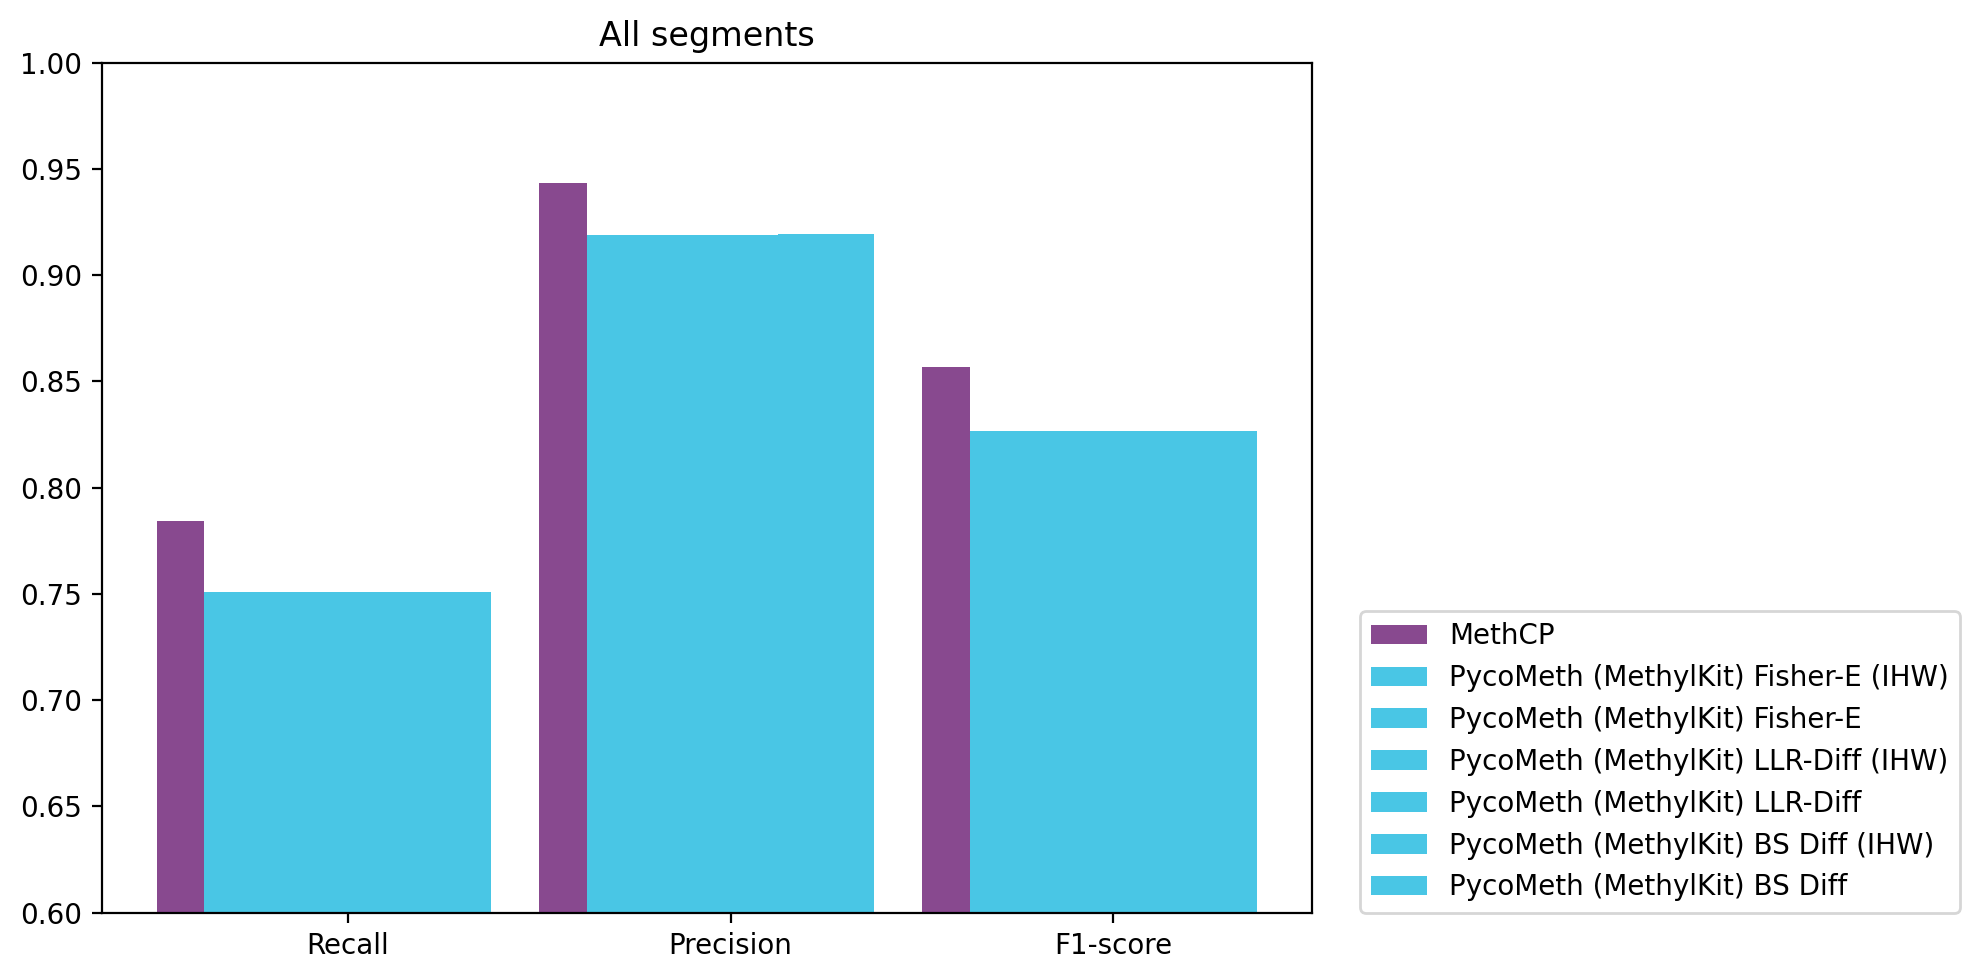

In [48]:
tools_include = ["MethCP", "PycoMeth (MethylKit) Fisher-E (IHW)", "PycoMeth (MethylKit) Fisher-E", "PycoMeth (MethylKit) LLR-Diff (IHW)", "PycoMeth (MethylKit) LLR-Diff", "PycoMeth (MethylKit) BS Diff (IHW)", "PycoMeth (MethylKit) BS Diff"]
tool_colors = {k:results.colors[k] for k in tools_include}
tool_patterns = {k:results.patterns.get(k,"") for k in tools_include}
gt = results.segments["GT"]
plot_measures(gt, "All segments", "f1_methylkit", tool_colors=tool_colors)

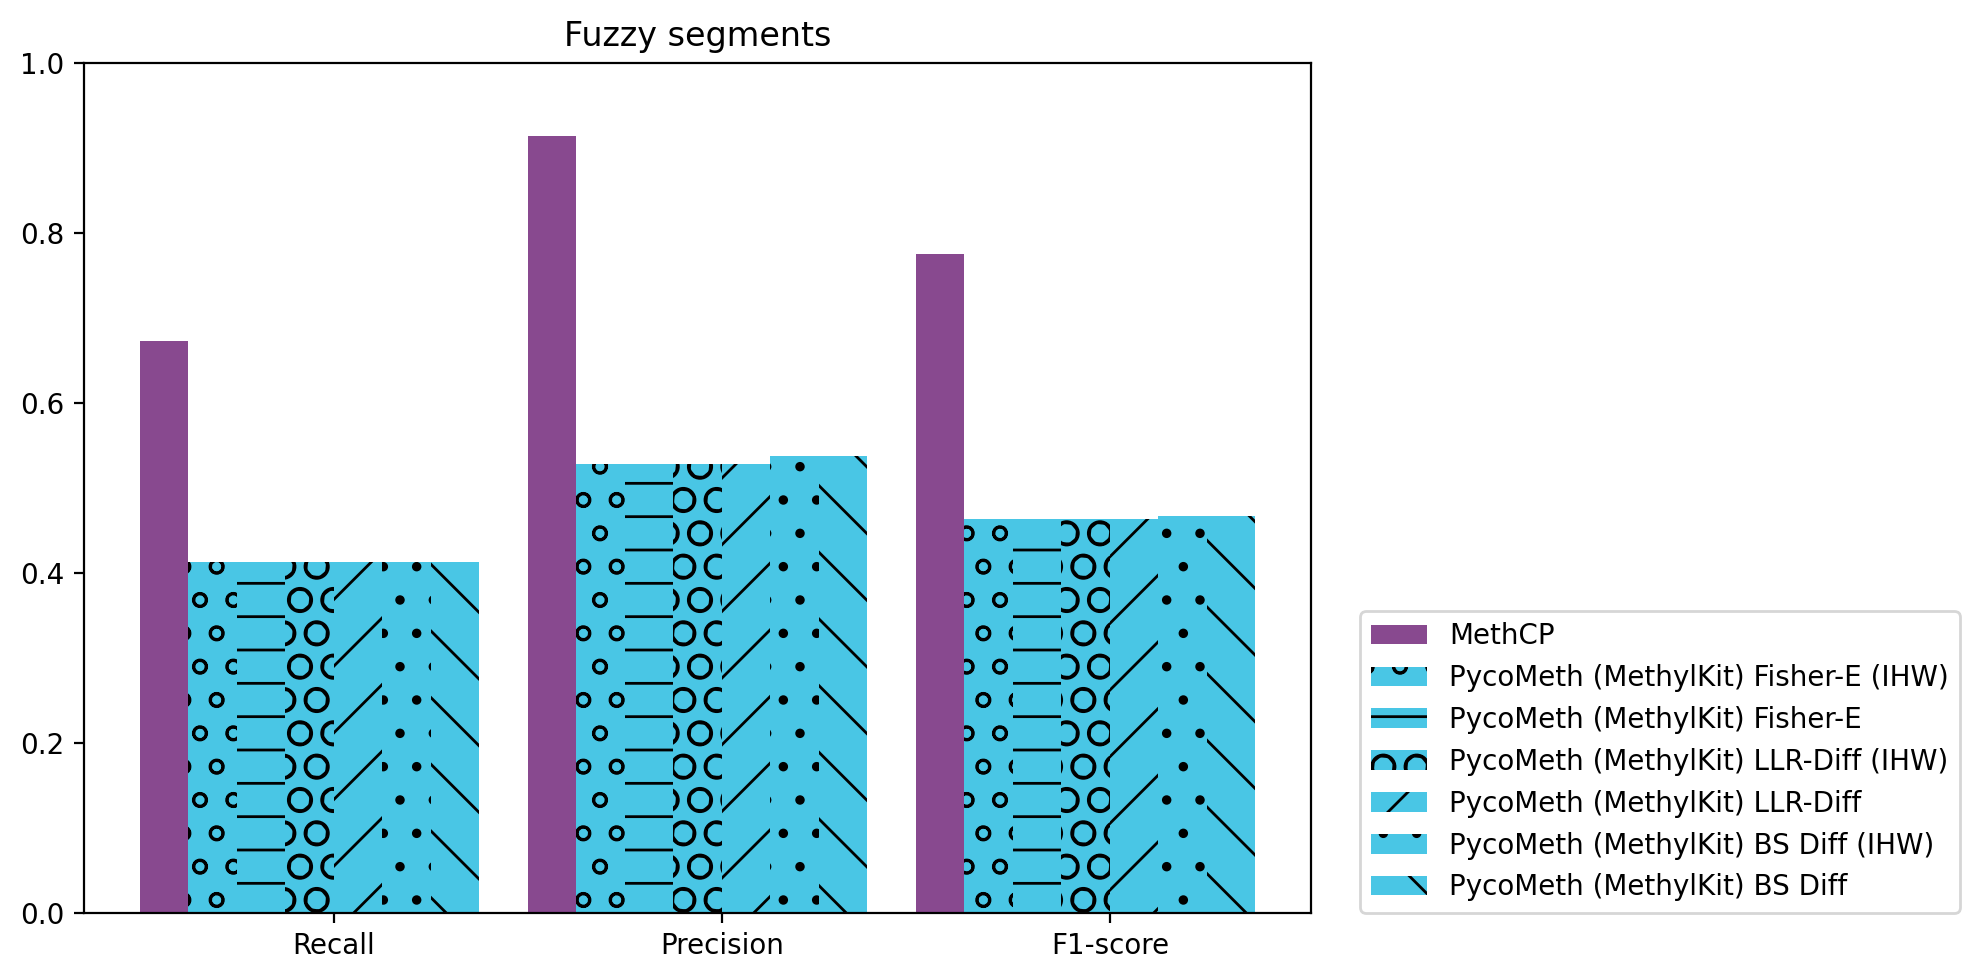

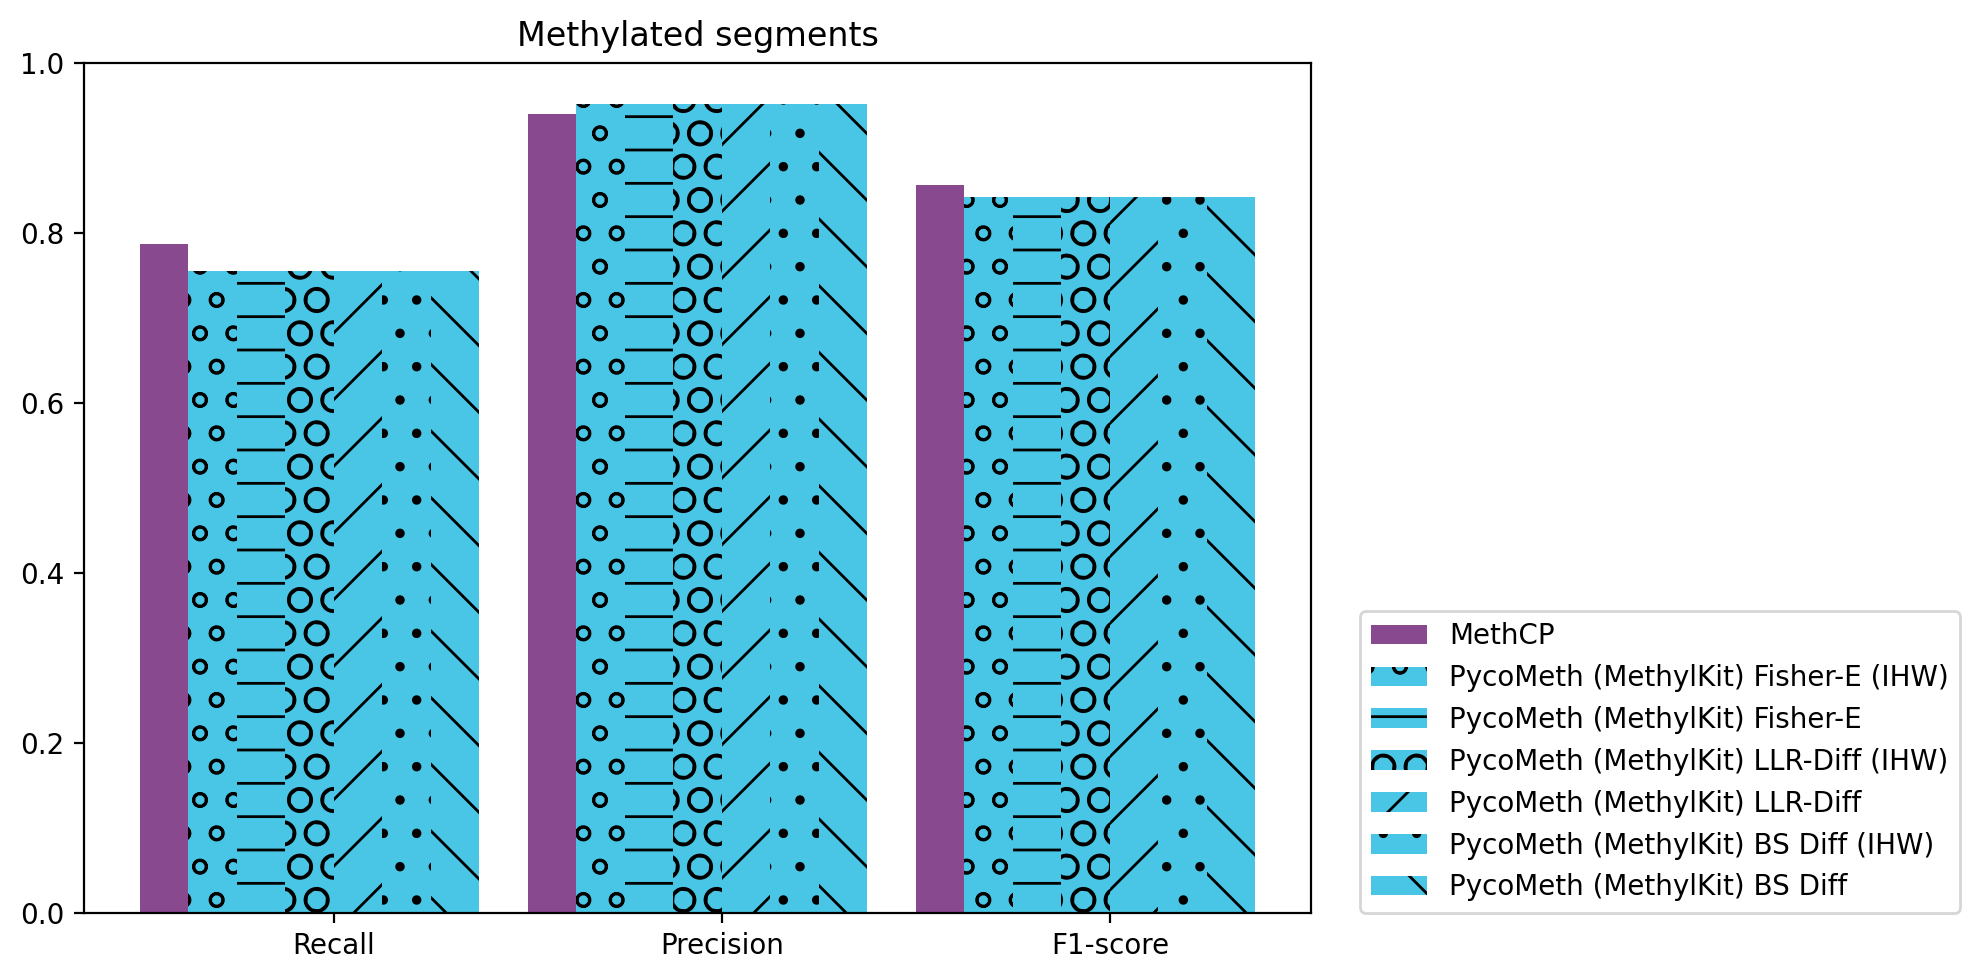

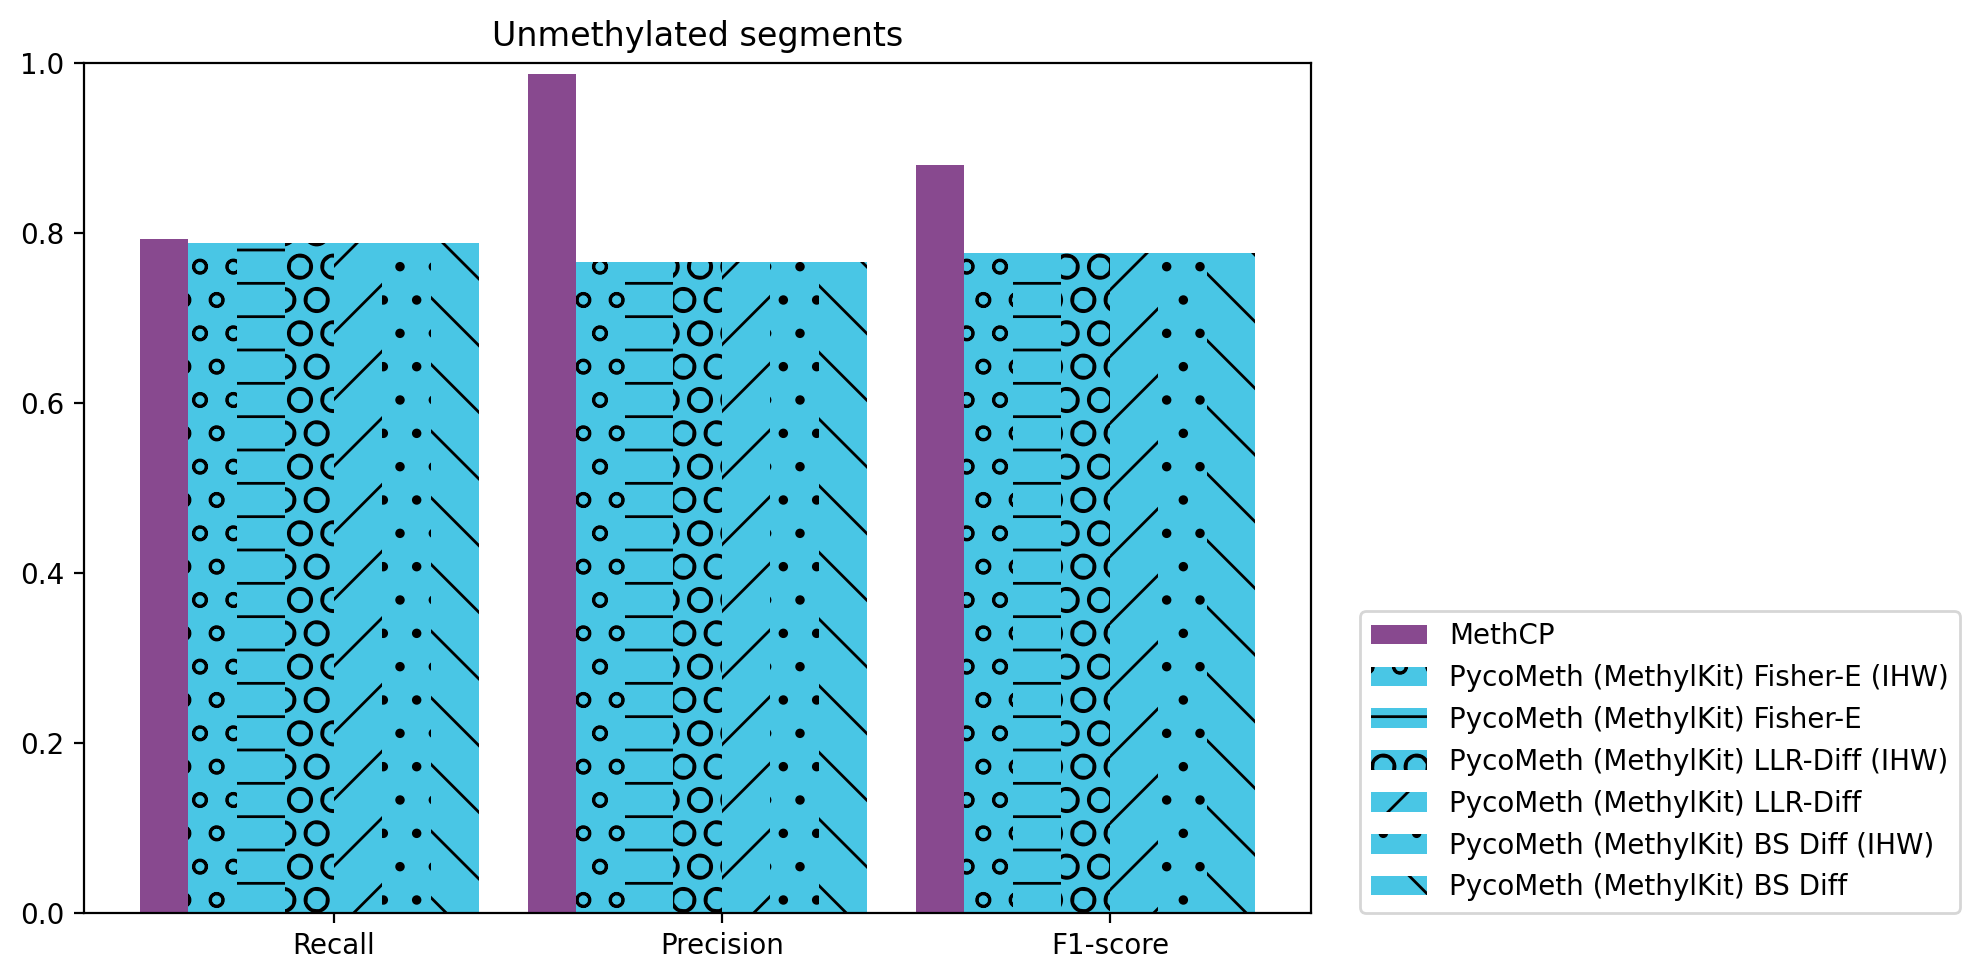

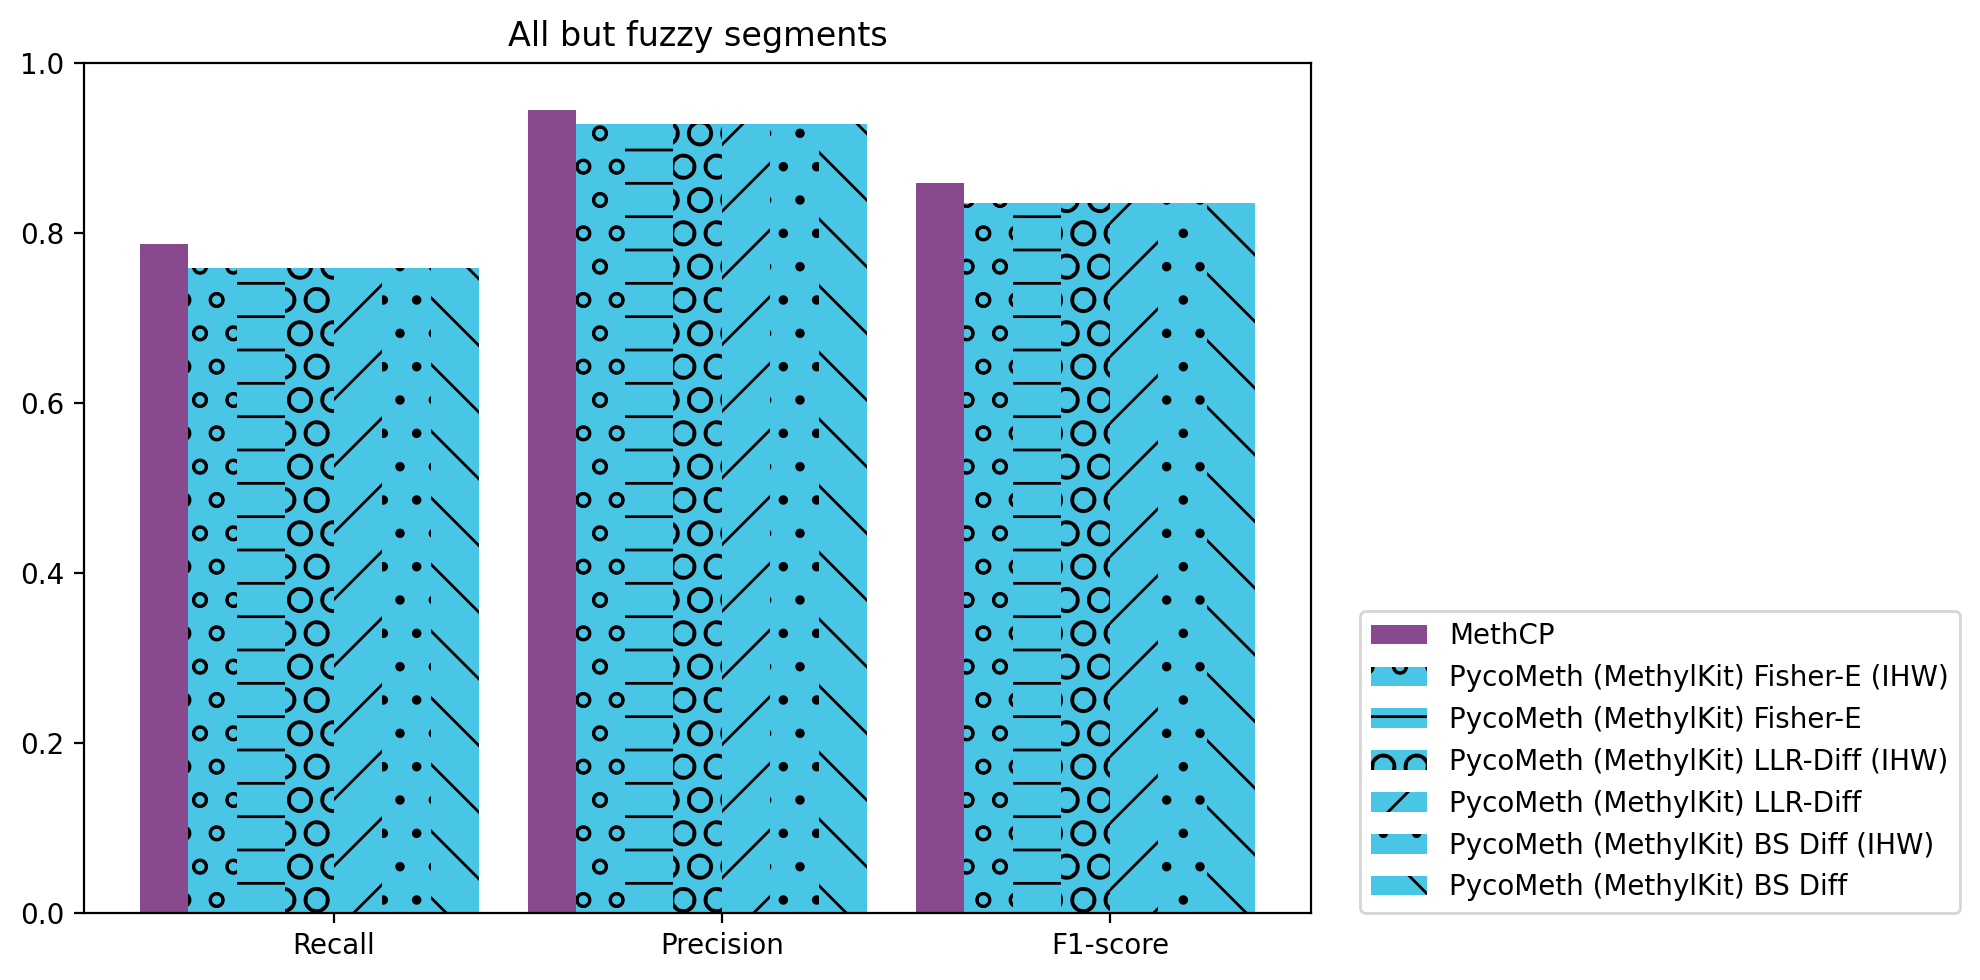

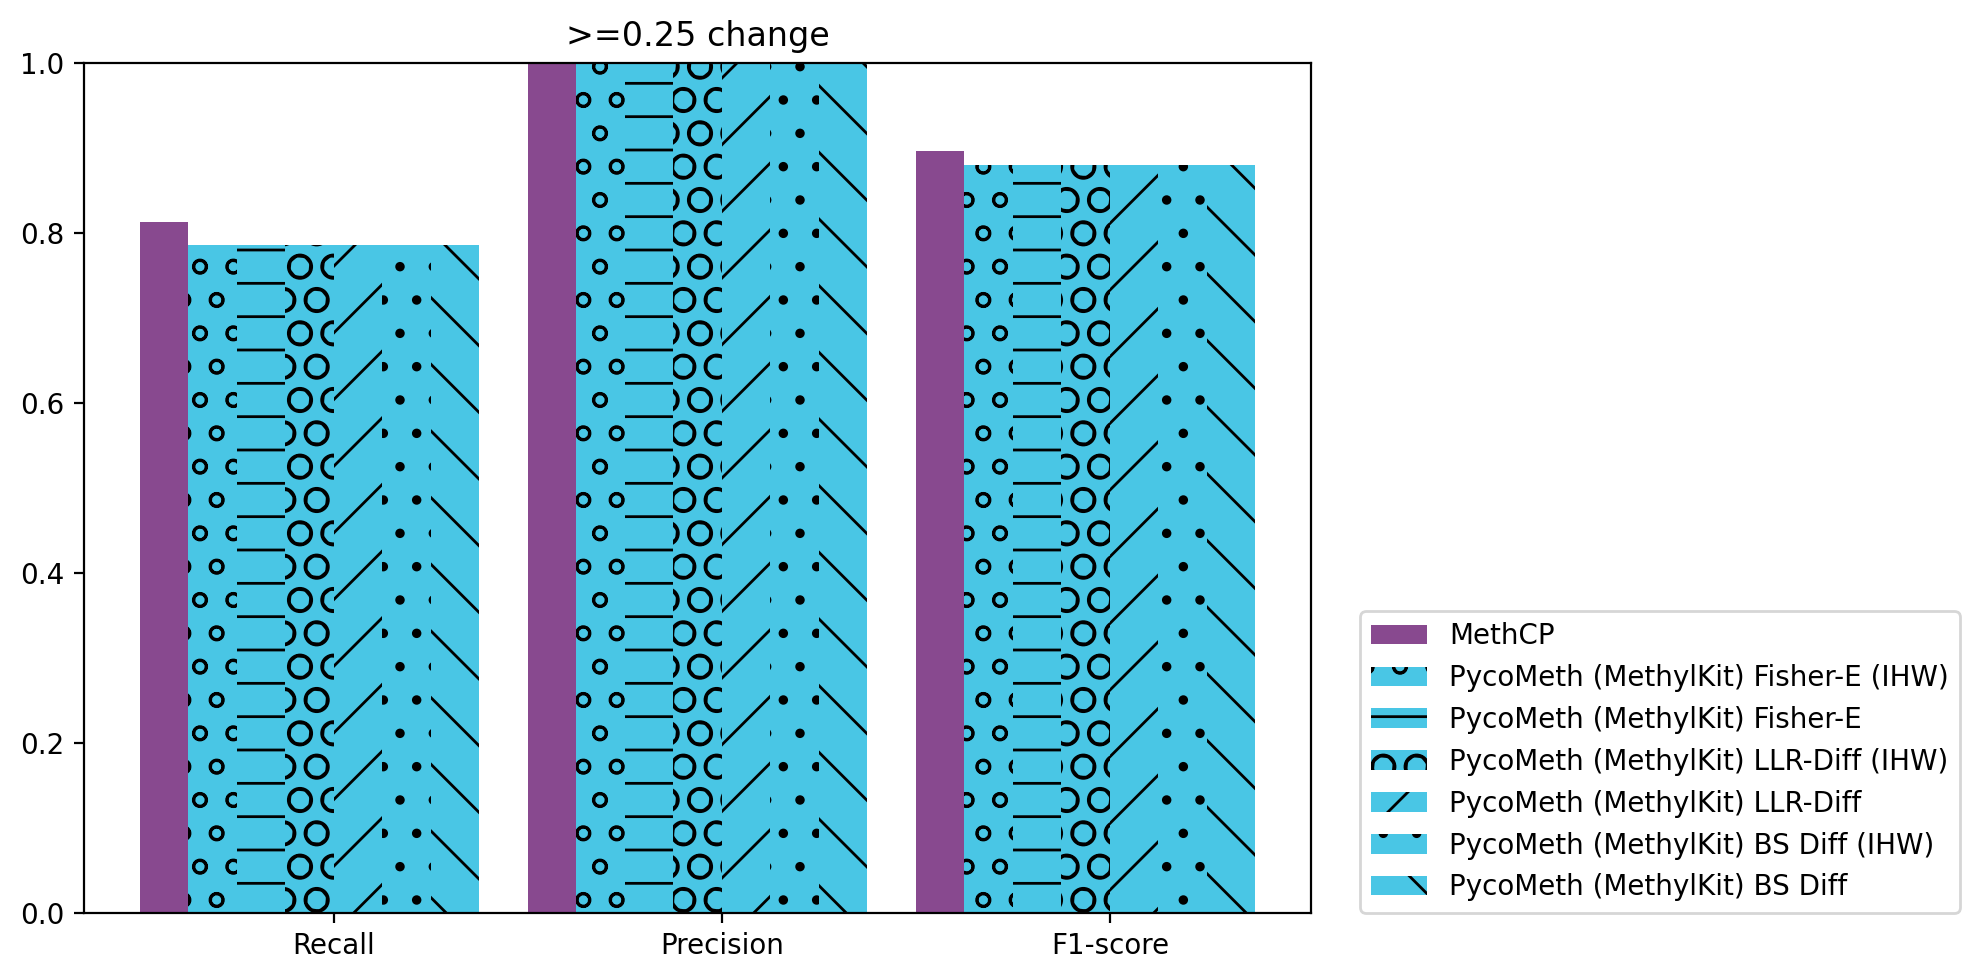

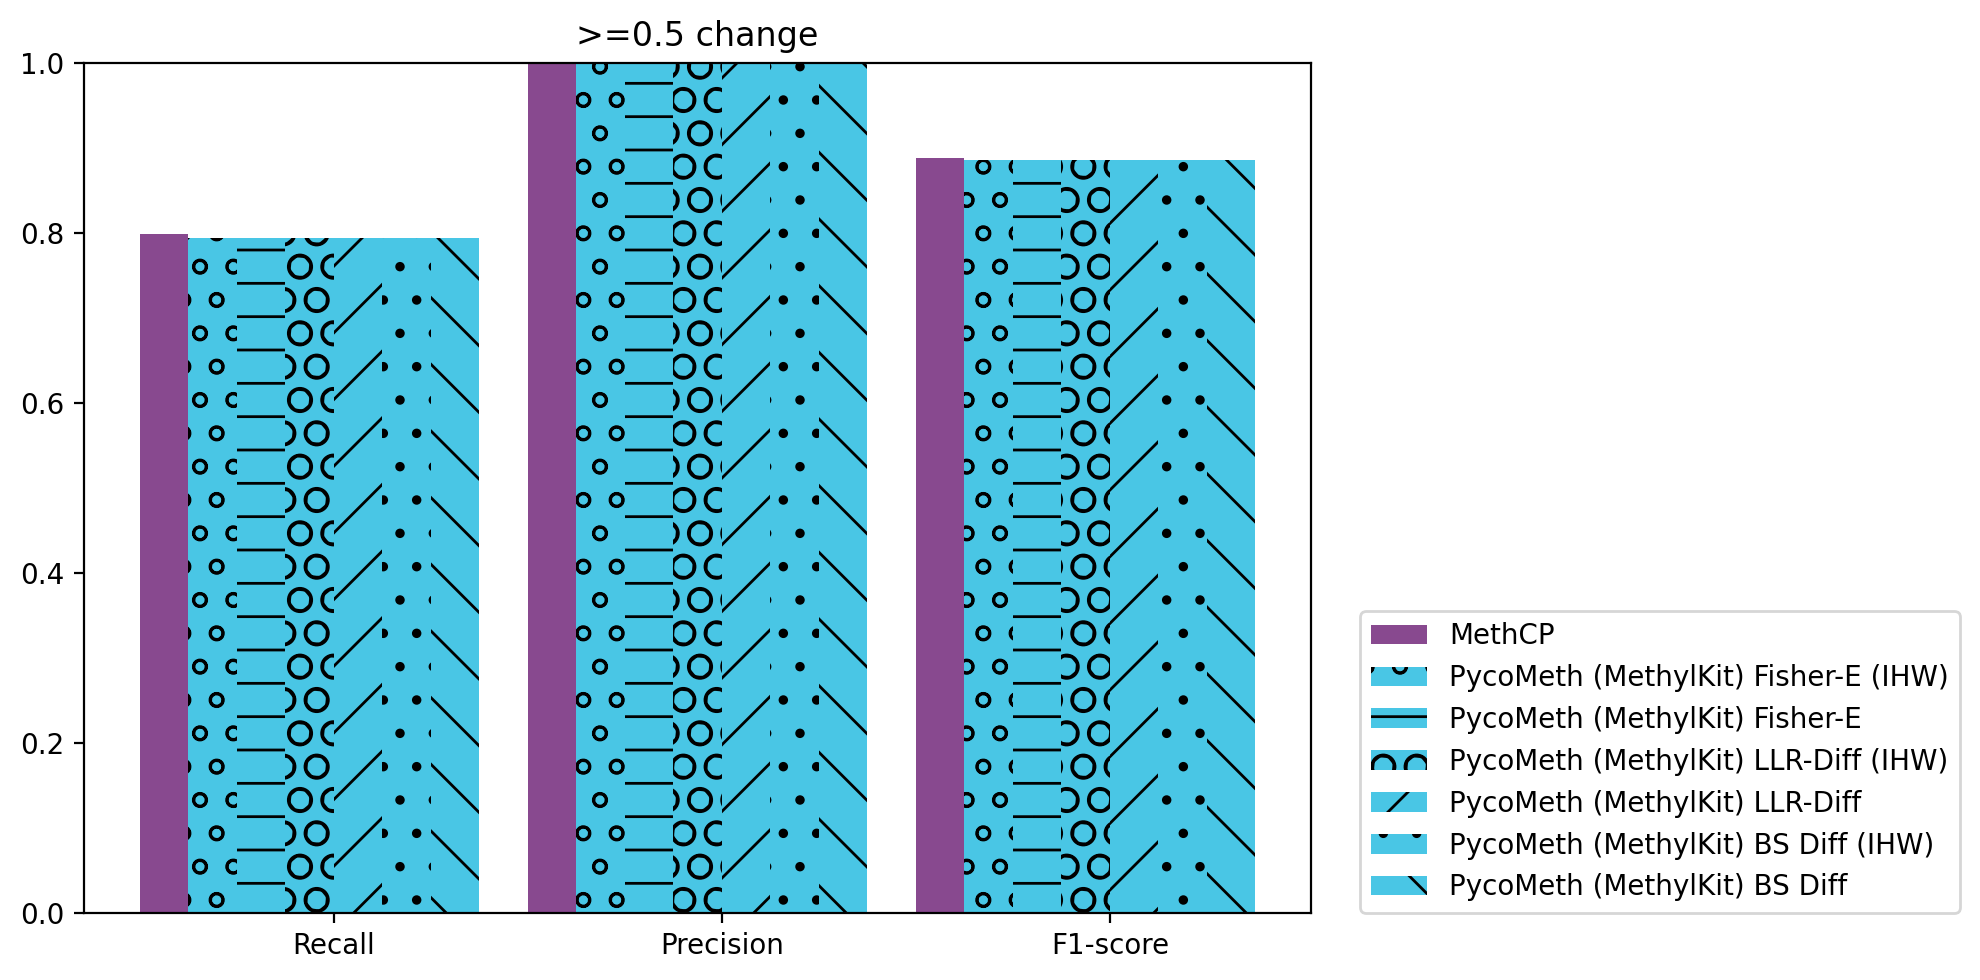

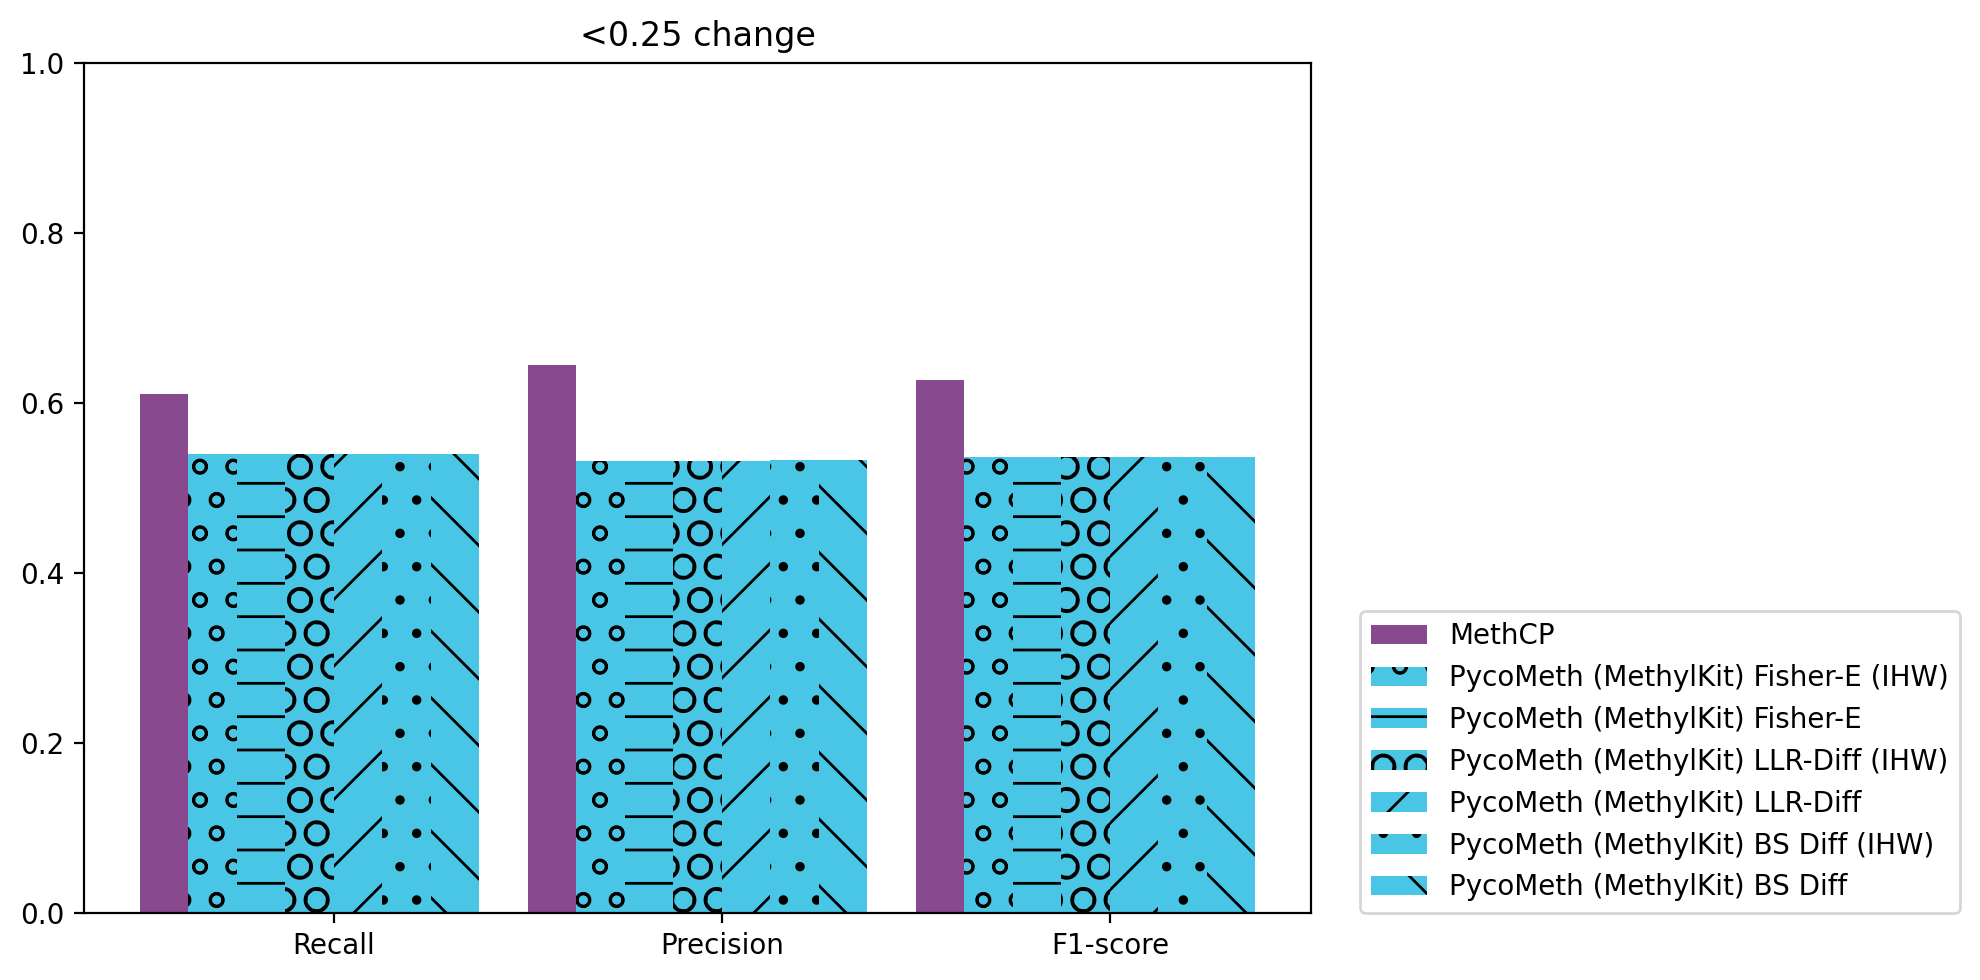

In [18]:
plot_measures(gt.loc[gt["segment_type"]==3].copy(), "Fuzzy segments", "roc_fuzzy", tool_colors=tool_colors, tool_patterns=tool_patterns)
plot_measures(gt.loc[gt["segment_type"]==2].copy(), "Methylated segments", "roc_methylated", tool_colors=tool_colors, tool_patterns=tool_patterns)
plot_measures(gt.loc[gt["segment_type"]==1].copy(), "Unmethylated segments", "roc_unmethylated", tool_colors=tool_colors, tool_patterns=tool_patterns)
plot_measures(gt.loc[gt["segment_type"]!=3].copy(), "All but fuzzy segments", "roc_notfuzzy", tool_colors=tool_colors, tool_patterns=tool_patterns)
plot_measures(gt.loc[gt["theta"].map(lambda x: abs(x) >= 0.25)].copy(), ">=0.25 change", "roc_effect_size_ge0.25", tool_colors=tool_colors, tool_patterns=tool_patterns)
plot_measures(gt.loc[gt["theta"].map(lambda x: abs(x) >= 0.5)].copy(), ">=0.5 change", "roc_effect_size_ge0.5", tool_colors=tool_colors, tool_patterns=tool_patterns)
plot_measures(gt.loc[gt["theta"].map(lambda x: abs(x) < 0.25)].copy(), "<0.25 change", "roc_effect_size_lt0.25", tool_colors=tool_colors, tool_patterns=tool_patterns)

In [19]:
results.segments["GT_empirical"] = results.segments["GT"].copy()
results.segments["GT_empirical"]["theta"] = results.segments["GT_empirical"].apply(lambda x: max(abs(x["theta"]), abs(x["diffmet"])) * (-1 if x["theta"] < 0 else 1), axis=1)

In [20]:
def plot_bar_diffmetcolored(x, key, diffmet_thresholds = [0.2, 0.3, 0.4, 0.6, 0.8, 1.0], cmap="jet"):
    cmap = matplotlib.cm.get_cmap(cmap)
    last_thres = 0.1
    left = 0
    segments = results.segments[key]
    for thres in diffmet_thresholds:
        color = cmap((thres+last_thres)/2)
        idx = segments["diffmet"].map(lambda x: last_thres < abs(x) <= thres)
        n = get_num_dmr_cpgs(key, additional_index=idx)
        plt.barh(x, n, left=left, color=color)
        left += n
        last_thres = thres

In [21]:
def get_dmrs(key, pval_thres = 0.05, min_diff = 0.1, additional_index=None):
    segments = results.segments[key]
    if additional_index is not None:
        segments = segments.loc[additional_index]
    segments = segments.loc[segments["adj_pvalue"] < pval_thres]
    segments = segments.loc[segments["diffmet"].map(lambda x: abs(x) > min_diff)]
    return segments

def get_num_dmr_cpgs(key, **kwargs):
    dmrs = get_dmrs(key, **kwargs)
    return len(unions(dmrs["CpGs"]))

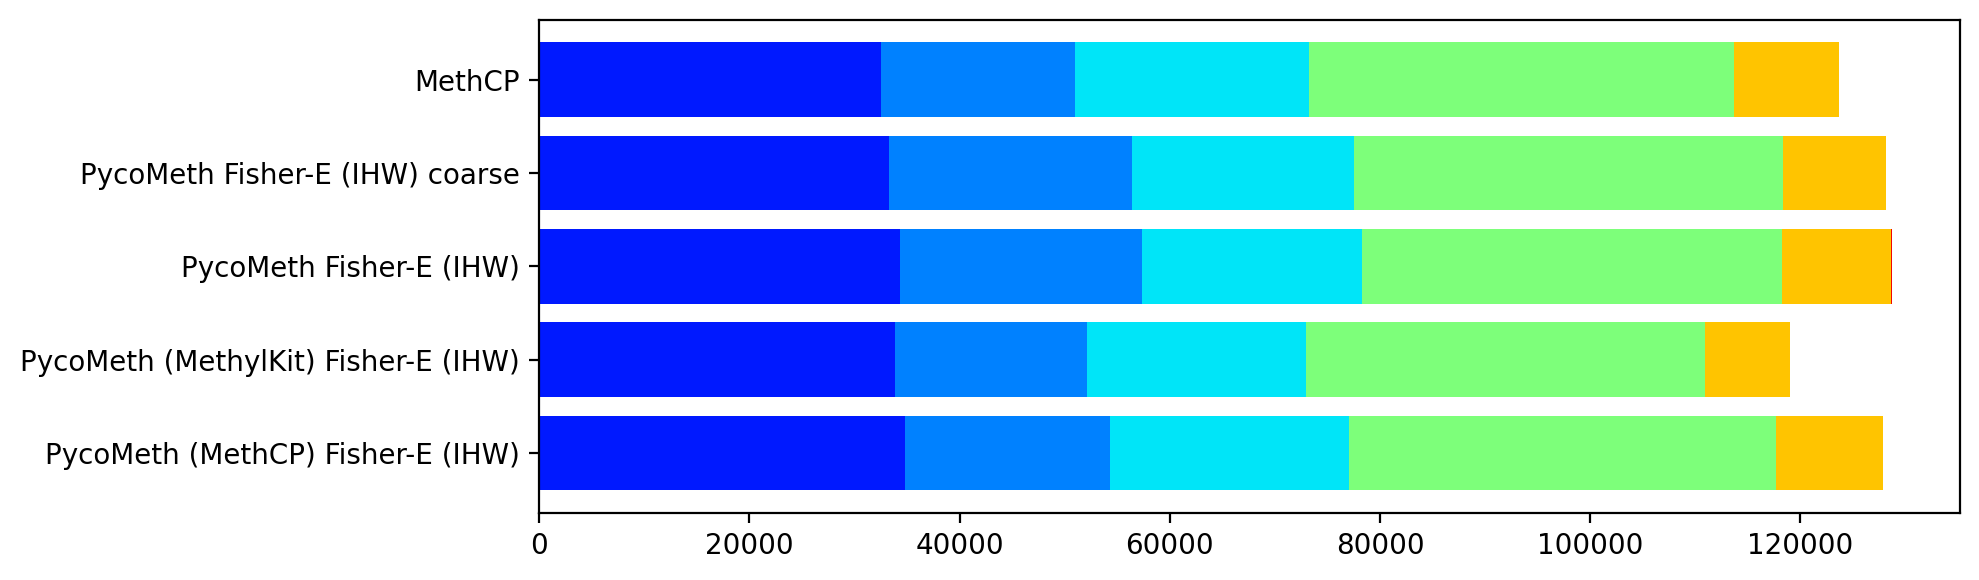

In [23]:
import matplotlib
with pa.open_multipage_pdf("simulated_fisher_ihw"):
    tools = ["MethCP", 'PycoMeth Fisher-E (IHW) coarse', 'PycoMeth Fisher-E (IHW)', 'PycoMeth (MethylKit) Fisher-E (IHW)', 'PycoMeth (MethCP) Fisher-E (IHW)'][::-1]
    pa.figure(figsize=(10, 3))
    for i, tool in enumerate(tools):
        plot_bar_diffmetcolored(i, tool)
    plt.yticks(np.arange(0, len(tools), 1), tools)
    pa.saveandshow()

In [10]:
rc = ResultComparer(results.segments)
#rc.segments["GT"] = gt
rc.remove_cpgs_not_in_gt("GT")

In [38]:
def plot_effect_size_cutoff_precision(tools_include):
    dm_thresholds = np.arange(0.1,1,0.01)
    tool_colors = {k:results.colors[k] for k in tools_include}
    for tool in tools_include:
        y = [rc.compute_predicted_effect_size_precision("GT", tool, diffmet_threshold=thres) for thres in dm_thresholds]
        plt.plot(dm_thresholds, y, color=tool_colors[tool])
    plt.xlabel("Maximum effect size")
    plt.ylabel("Precision")
    plt.xticks(dm_thresholds[::10], [f"{thres:.1f}" for thres in dm_thresholds[::10]])
    plt.ylim(0,1)

def plot_effect_size_cutoff_recall(tools_include):
    dm_thresholds = np.arange(0.15,1,0.05)
    tool_colors = {k:results.colors[k] for k in tools_include}
    for tool in tools_include:
        y = [rc.compute_predicted_effect_size_recall("GT", tool, diffmet_threshold=thres) for thres in dm_thresholds]
        plt.plot(dm_thresholds, y, color=tool_colors[tool])
    plt.xlabel("Maximum GT effect size")
    plt.ylabel("Recall")
    plt.xticks(dm_thresholds[::2], [f"{thres:.1f}" for thres in dm_thresholds[::2]])
    plt.ylim(0,1)

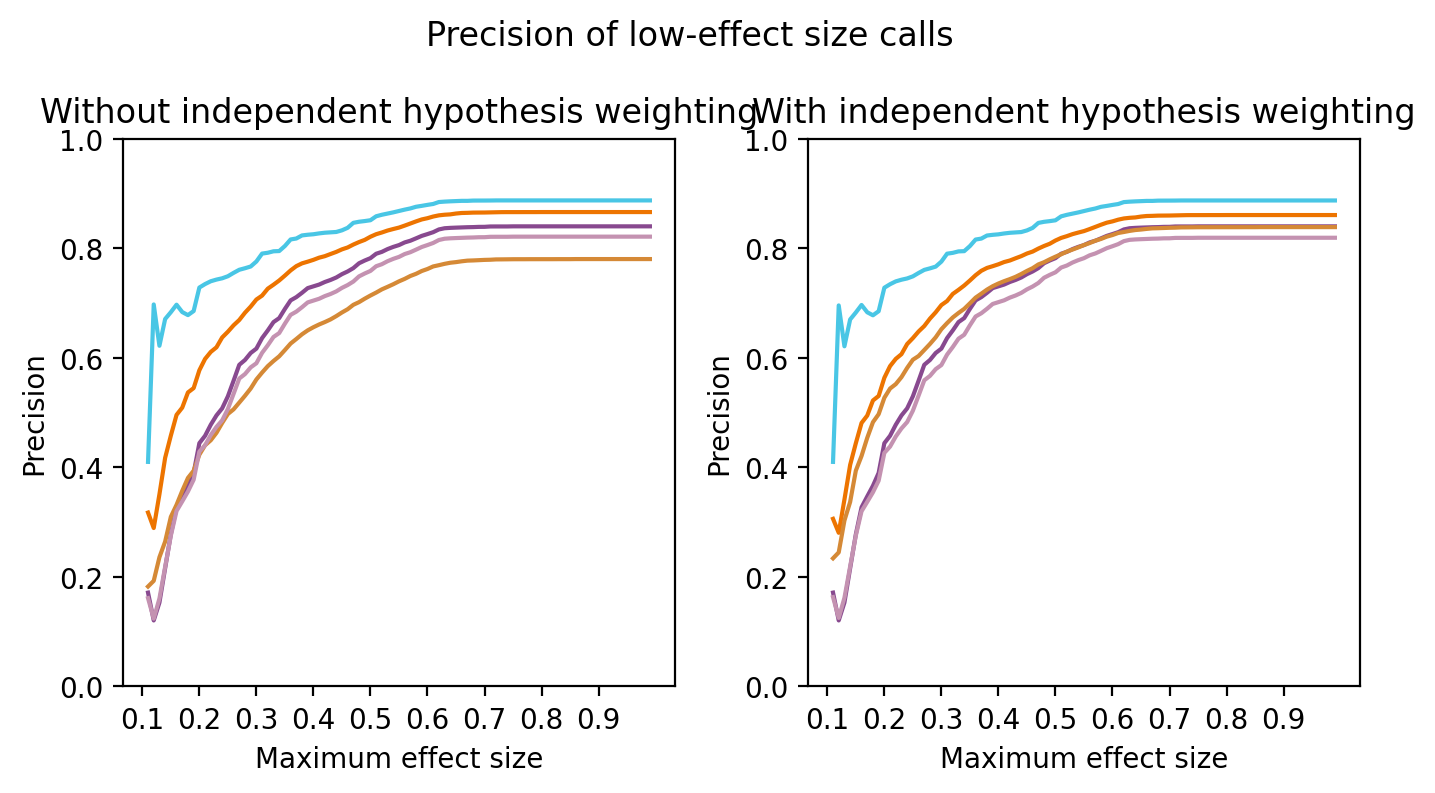

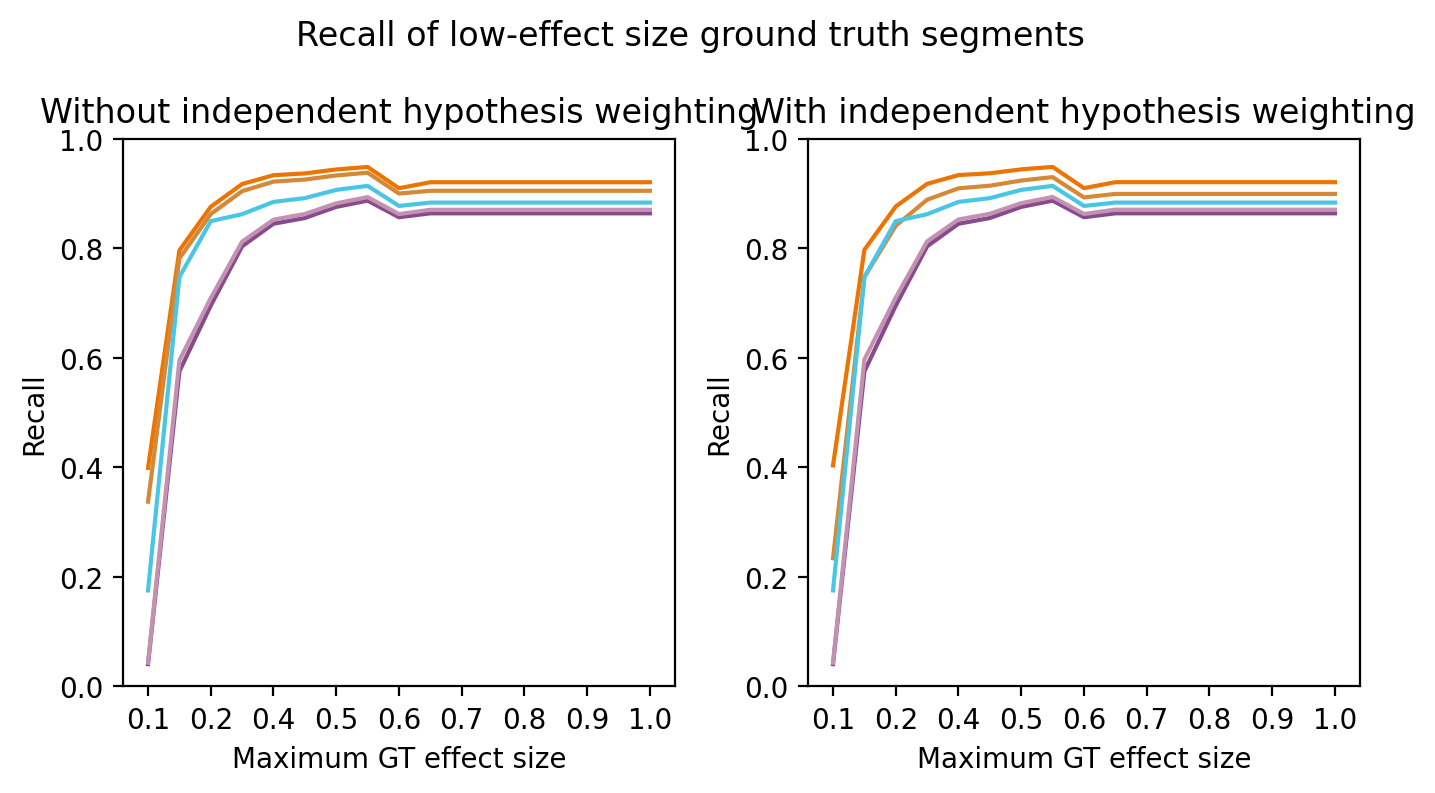

In [39]:
fig, ax = pa.subplots(1,2, figsize=(7,4))
fig.suptitle("Precision of low-effect size calls")
plt.sca(ax[0])
plt.title("Without independent hypothesis weighting")
tools_include = ["MethCP", "PycoMeth Fisher-E coarse", "PycoMeth Fisher-E", "PycoMeth (MethylKit) Fisher-E", "PycoMeth (MethCP) Fisher-E"]
plot_effect_size_cutoff_precision(tools_include)
plt.sca(ax[1])
plt.title("With independent hypothesis weighting")
tools_include = ["MethCP", "PycoMeth Fisher-E (IHW) coarse", "PycoMeth Fisher-E (IHW)", "PycoMeth (MethylKit) Fisher-E (IHW)", "PycoMeth (MethCP) Fisher-E (IHW)"]
plot_effect_size_cutoff_precision(tools_include)
pa.saveandshow("simulation_precision_effect_size")


fig, ax = pa.subplots(1,2, figsize=(7,4))
fig.suptitle("Recall of low-effect size ground truth segments")
plt.sca(ax[0])
plt.title("Without independent hypothesis weighting")
tools_include = ["MethCP", "PycoMeth Fisher-E coarse", "PycoMeth Fisher-E", "PycoMeth (MethylKit) Fisher-E", "PycoMeth (MethCP) Fisher-E"]
plot_effect_size_cutoff_recall(tools_include)
plt.sca(ax[1])
plt.title("With independent hypothesis weighting")
tools_include = ["MethCP", "PycoMeth Fisher-E (IHW) coarse", "PycoMeth Fisher-E (IHW)", "PycoMeth (MethylKit) Fisher-E (IHW)", "PycoMeth (MethCP) Fisher-E (IHW)"]
plot_effect_size_cutoff_recall(tools_include)
pa.saveandshow("simulation_recall_effect_size")

In [54]:
import pylab as plt
from matplotlib_venn import venn3, venn3_circles

In [ ]:
sc.predicted_segments["PycoMeth coarse"]

In [14]:
import venn
from matplotlib.colors import to_rgba
import importlib

In [15]:
def plot_venn(filename, tools, colors=None):
    if colors is not None:
        venn._venn.generate_colors = lambda *args, **kwargs: [to_rgba(colors[k], alpha=0.5) for k in tools]
    else:
        importlib.reload(venn)
    cgs_for_venn = {tool: unions(rc.get(tool, pval_threshold=0.05)["CpGs"]) for tool in tools}
    pa.figure()
    venn.venn(cgs_for_venn, fmt="{percentage:.1f}%")
    pa.saveandshow(filename)

<Figure size 1200x800 with 0 Axes>

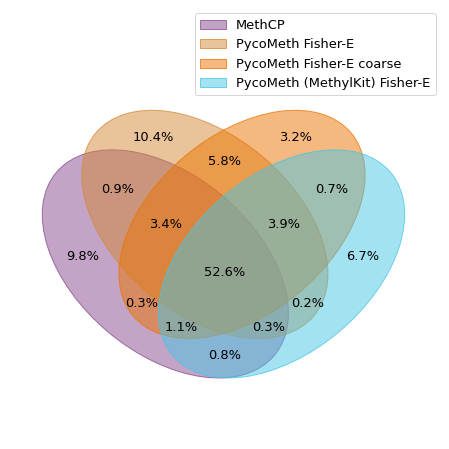

In [20]:
tools_include = ["MethCP",  "PycoMeth Fisher-E", "PycoMeth Fisher-E coarse", "PycoMeth (MethylKit) Fisher-E"]
plot_venn("simulation_venn_tools", tools_include, colors=results.colors)


<Figure size 1200x800 with 0 Axes>

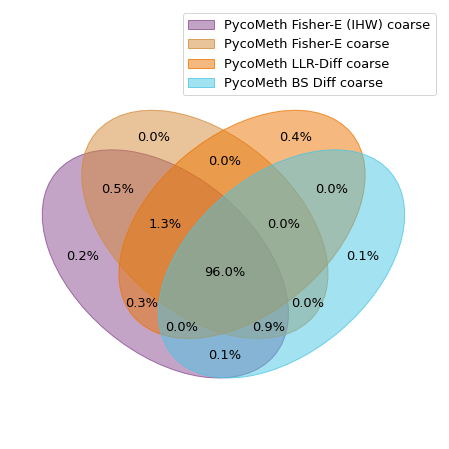

In [28]:
tools_include = ["PycoMeth Fisher-E (IHW) coarse", "PycoMeth Fisher-E coarse", "PycoMeth LLR-Diff coarse", "PycoMeth BS Diff coarse"]
plot_venn("simulation_venn_types", tools_include, colors=None)